In [1]:
%pip install xgboost nfl_data_py pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
# NFL Game Prediction using nfl_data_py
# Updated version of NFL prediction pipeline using modern, maintained data source

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot  
import warnings
import os
warnings.filterwarnings('ignore')

# Core ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.calibration import CalibratedClassifierCV as CCV
from sklearn.pipeline import Pipeline

# Advanced ML libraries
try: 
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not available. Install with: pip install xgboost")

# NFL data library
try:
    import nfl_data_py as nfl
    HAS_NFL_DATA = True
except ImportError:
    HAS_NFL_DATA = False
    print("nfl_data_py not available. Install with: pip install nfl_data_py")

class NFLGamePredictor:
    def __init__(self):
        self.models = {}
        self.best_features = []
        self.scaler = StandardScaler()
        self.final_model = None
        
    def collect_data(self, start_year=2010, end_year=2024, save_csv=True, data_folder='nfl_data'):
        """Collect comprehensive NFL data using nfl_data_py and save as CSV files"""
        
        if not HAS_NFL_DATA:
            raise ImportError("nfl_data_py is required. Install with: pip install nfl_data_py")
        
        print(f"Collecting NFL data from {start_year} to {end_year}...")
        
        # Create data folder if it doesn't exist
        if save_csv and not os.path.exists(data_folder):
            os.makedirs(data_folder)
            print(f"Created data folder: {data_folder}")
        
        years = list(range(start_year, end_year + 1))
        
        # Get play-by-play data for game-level statistics
        print("Downloading play-by-play data...")
        try:
            pbp_data = nfl.import_pbp_data(years)
            print(f"Play-by-play data downloaded successfully")
        except Exception as e:
            print(f"Error downloading play-by-play data: {e}")
            # Try with reduced year range
            years = list(range(start_year, 2024 + 1))
            pbp_data = nfl.import_pbp_data(years)
            print(f"Play-by-play data downloaded (adjusted to {start_year}-2024)")
        
        # Get team information
        print("Downloading team information...")
        teams = nfl.import_team_desc()
        team_dict = teams.set_index('team_abbr')['team_name'].to_dict()
        
        # Get weekly data for season-long team statistics
        print("Downloading weekly team data...")
        try:
            weekly_data = nfl.import_weekly_data(years)
            print(f"Weekly data downloaded successfully")
        except Exception as e:
            print(f"Error downloading weekly data: {e}")
            print("Trying with 2020-2024 data only...")
            # Fall back to confirmed available years
            years_safe = list(range(2020, 2024 + 1))
            weekly_data = nfl.import_weekly_data(years_safe)
            print(f"Weekly data downloaded (2020-2024)")
        
        # Get schedule data
        print("Downloading schedule data...")
        try:
            schedule_data = nfl.import_schedules(years)
            print(f"Schedule data downloaded successfully")
        except Exception as e:
            print(f"Error downloading schedule data: {e}")
            print("Trying with 2020-2024 data only...")
            # Fall back to confirmed available years
            years_safe = list(range(2020, 2024 + 1))
            schedule_data = nfl.import_schedules(years_safe)
            print(f"Schedule data downloaded (2020-2024)")
        
        # Try to get 2025 Week 1 data separately if available
        print("Attempting to download 2025 Week 1 data...")
        try:
            pbp_2025 = nfl.import_pbp_data([2025])
            if not pbp_2025.empty:
                pbp_data = pd.concat([pbp_data, pbp_2025], ignore_index=True)
                print("2025 play-by-play data added")
            
            weekly_2025 = nfl.import_weekly_data([2025])
            if not weekly_2025.empty:
                weekly_data = pd.concat([weekly_data, weekly_2025], ignore_index=True)
                print("2025 weekly data added")
                
            schedule_2025 = nfl.import_schedules([2025])
            if not schedule_2025.empty:
                schedule_data = pd.concat([schedule_data, schedule_2025], ignore_index=True)
                print("2025 schedule data added")
        except Exception as e:
            print(f"2025 data not available yet: {e}")
            print("Proceeding with 2020-2024 data only")
        
        print(f"Collected {len(pbp_data)} play-by-play records")
        print(f"Collected {len(weekly_data)} weekly team records") 
        print(f"Collected {len(schedule_data)} scheduled games")
        
        # Save data as CSV files if requested
        if save_csv:
            print(f"\nSaving data to CSV files in '{data_folder}' folder...")
            
            # Save play-by-play data (this will be large)
            pbp_file = os.path.join(data_folder, f'pbp_data_{start_year}_{end_year}.csv')
            pbp_data.to_csv(pbp_file, index=False)
            print(f"Saved play-by-play data: {pbp_file} ({len(pbp_data):,} rows)")
            
            # Save weekly data
            weekly_file = os.path.join(data_folder, f'weekly_data_{start_year}_{end_year}.csv')
            weekly_data.to_csv(weekly_file, index=False)
            print(f"Saved weekly data: {weekly_file} ({len(weekly_data):,} rows)")
            
            # Save schedule data
            schedule_file = os.path.join(data_folder, f'schedule_data_{start_year}_{end_year}.csv')
            schedule_data.to_csv(schedule_file, index=False)
            print(f"Saved schedule data: {schedule_file} ({len(schedule_data):,} rows)")
            
            # Save team information
            teams_file = os.path.join(data_folder, 'team_info.csv')
            teams.to_csv(teams_file, index=False)
            print(f"Saved team info: {teams_file} ({len(teams):,} rows)")
            
            # Save a sample of each dataset for quick inspection
            print(f"\nSaving sample data for quick inspection...")
            
            # Sample play-by-play (first 1000 rows)
            pbp_sample_file = os.path.join(data_folder, 'pbp_sample.csv')
            pbp_data.head(1000).to_csv(pbp_sample_file, index=False)
            print(f"Saved PBP sample: {pbp_sample_file} (1,000 rows)")
            
            # Sample weekly data (recent season)
            weekly_sample = weekly_data[weekly_data['season'] >= end_year - 1]
            weekly_sample_file = os.path.join(data_folder, 'weekly_sample.csv')
            weekly_sample.to_csv(weekly_sample_file, index=False)
            print(f"Saved weekly sample: {weekly_sample_file} ({len(weekly_sample):,} rows from {end_year-1}-{end_year})")
            
            # Show column information
            print(f"\nDATA STRUCTURE OVERVIEW:")
            print("="*50)
            print(f"Play-by-Play Columns ({len(pbp_data.columns)}): {list(pbp_data.columns[:10])}...")
            print(f"Weekly Data Columns ({len(weekly_data.columns)}): {list(weekly_data.columns)}")
            print(f"Schedule Columns ({len(schedule_data.columns)}): {list(schedule_data.columns)}")
            print(f"Team Info Columns ({len(teams.columns)}): {list(teams.columns)}")
            
            print(f"\nDATA SAVED SUCCESSFULLY!")
            print(f"Check the '{data_folder}' folder to examine the downloaded data.")
        
        return pbp_data, weekly_data, schedule_data, team_dict
    
    def _calculate_injury_percentage(self, team_data):
        """
        Calculate estimated injury percentage based on available performance metrics
        
        This method estimates team injury impact by analyzing performance consistency
        and key player availability indicators in the data.
        """
        
        # If we have specific injury data columns, use them
        if 'injuries' in team_data.columns:
            return team_data['injuries'].mean()
        
        # Estimate injury impact based on performance variance and available metrics
        # Higher variance in key stats might indicate injury-related inconsistency
        
        injury_indicators = []
        
        # 1. Passing performance consistency (QB health indicator)
        if 'passing_yards' in team_data.columns and len(team_data) > 1:
            passing_std = team_data['passing_yards'].std()
            passing_mean = team_data['passing_yards'].mean()
            if passing_mean > 0:
                passing_variance = (passing_std / passing_mean) * 100
                injury_indicators.append(min(passing_variance, 30))  # Cap at 30%
        
        # 2. Rushing performance consistency (RB/OL health indicator)
        if 'rushing_yards' in team_data.columns and len(team_data) > 1:
            rushing_std = team_data['rushing_yards'].std()
            rushing_mean = team_data['rushing_yards'].mean()
            if rushing_mean > 0:
                rushing_variance = (rushing_std / rushing_mean) * 100
                injury_indicators.append(min(rushing_variance, 25))  # Cap at 25%
        
        # 3. Completion percentage consistency (QB/WR health indicator)
        if 'completions' in team_data.columns and 'passing_attempts' in team_data.columns:
            comp_pct = team_data['completions'] / (team_data['passing_attempts'] + 0.1)  # Avoid division by zero
            if len(comp_pct) > 1:
                comp_std = comp_pct.std()
                comp_variance = comp_std * 100
                injury_indicators.append(min(comp_variance, 20))  # Cap at 20%
        
        # 4. Fantasy points consistency (overall team health)
        if 'fantasy_points' in team_data.columns and len(team_data) > 1:
            fp_std = team_data['fantasy_points'].std()
            fp_mean = team_data['fantasy_points'].mean()
            if fp_mean > 0:
                fp_variance = (fp_std / fp_mean) * 100
                injury_indicators.append(min(fp_variance, 35))  # Cap at 35%
        
        # Calculate weighted average injury percentage
        if injury_indicators:
            # Weight more recent games higher (if we have game order info)
            weights = [1.0] * len(injury_indicators)  
            weighted_avg = sum(i * w for i, w in zip(injury_indicators, weights)) / sum(weights)
            
            # Normalize to 0-100% range and apply league baseline
            # NFL teams typically have 10-25% of roster dealing with some injury
            baseline_injury_rate = 15.0  # League average baseline
            estimated_injury_pct = min(max(weighted_avg, 5.0), 40.0)  # 5-40% range
            
            # Blend with baseline for more realistic estimates
            final_injury_pct = (estimated_injury_pct * 0.7) + (baseline_injury_rate * 0.3)
            
            return final_injury_pct
        
        # Default injury rate if no data available
        return 15.0  # NFL league average
    
    def _calculate_defensive_stats(self, weekly_data, schedule_data, season, week):
        """
        Calculate defensive statistics (yards/points allowed) for each team.
        OPTIMIZED VERSION - Pre-aggregate weekly data for faster lookups.
        """
        defensive_stats = {}
        
        # Filter to relevant season/weeks
        season_schedule = schedule_data[
            (schedule_data['season'] == season) & 
            (schedule_data['week'] < week)
        ].copy()
        
        if season_schedule.empty:
            return {}
        
        # PRE-AGGREGATE: Create team totals per week (MUCH FASTER)
        season_weekly = weekly_data[
            (weekly_data['season'] == season) & 
            (weekly_data['week'] < week)
        ]
        
        if season_weekly.empty:
            return {}
        
        # Group by team and week, sum all player stats
        team_week_totals = season_weekly.groupby(['recent_team', 'week']).agg({
            'passing_yards': 'sum',
            'rushing_yards': 'sum'
        }).reset_index()
        team_week_totals['total_yards'] = team_week_totals['passing_yards'] + team_week_totals['rushing_yards']
        
        # CRITICAL OPTIMIZATION: Create lookup dictionary for O(1) access instead of repeated filtering
        yards_lookup = {}
        for _, row in team_week_totals.iterrows():
            key = (row['recent_team'], row['week'])
            yards_lookup[key] = row['total_yards']
        
        # Get all unique teams from schedule (vectorized)
        all_teams = set(pd.concat([
            season_schedule['home_team'].dropna(),
            season_schedule['away_team'].dropna()
        ]).unique())
        
        for team in all_teams:
            # Get all games for this team (one filter operation)
            team_home = season_schedule[season_schedule['home_team'] == team]
            team_away = season_schedule[season_schedule['away_team'] == team]
            
            total_yards_allowed = 0
            total_points_allowed = 0
            games_count = 0
            
            # Process home games (defending against away team)
            for _, game in team_home.iterrows():
                if pd.notna(game.get('away_score')):
                    opponent = game['away_team']
                    game_week = game['week']
                    points_allowed = game['away_score']
                    
                    # O(1) dictionary lookup instead of DataFrame filter
                    yards_allowed = yards_lookup.get((opponent, game_week), 0)
                    if yards_allowed > 0:
                        total_yards_allowed += yards_allowed
                        total_points_allowed += points_allowed
                        games_count += 1
            
            # Process away games (defending against home team)
            for _, game in team_away.iterrows():
                if pd.notna(game.get('home_score')):
                    opponent = game['home_team']
                    game_week = game['week']
                    points_allowed = game['home_score']
                    
                    # O(1) dictionary lookup
                    yards_allowed = yards_lookup.get((opponent, game_week), 0)
                    if yards_allowed > 0:
                        total_yards_allowed += yards_allowed
                        total_points_allowed += points_allowed
                        games_count += 1
            
            # Calculate per-game averages
            if games_count > 0:
                defensive_stats[team] = {
                    'def_yards_allowed_pg': total_yards_allowed / games_count,
                    'def_points_allowed_pg': total_points_allowed / games_count
                }
            else:
                defensive_stats[team] = {
                    'def_yards_allowed_pg': 0,
                    'def_points_allowed_pg': 0
                }
        
        return defensive_stats
    
    def create_team_features(self, weekly_data, season, week, schedule_data=None):
        """
        Create team-level features for a specific season/week.
        
        CRITICAL: weekly_data contains PLAYER-level statistics.
        We must aggregate multiple players per team per week to get team totals.
        """
        
        # Filter data up to the current week
        season_data = weekly_data[
            (weekly_data['season'] == season) & 
            (weekly_data['week'] < week)
        ]
        
        if season_data.empty:
            return {}
        
        # Check if 'recent_team' column exists
        if 'recent_team' not in season_data.columns:
            print("Warning: 'recent_team' column not found in weekly_data")
            return {}
        
        # Calculate defensive stats if schedule data provided
        defensive_stats = {}
        if schedule_data is not None:
            defensive_stats = self._calculate_defensive_stats(weekly_data, schedule_data, season, week)
        
        # Calculate season averages for each team
        team_features = {}
        
        for team in season_data['recent_team'].unique():
            team_data = season_data[season_data['recent_team'] == team]
            
            if len(team_data) == 0:
                continue
            
            # CRITICAL FIX: Aggregate player stats into team totals per week
            # Group by week and sum all players' stats to get team totals
            team_weekly = team_data.groupby('week').agg({
                'passing_yards': 'sum',
                'rushing_yards': 'sum',
                'completions': 'sum',
                'passing_tds': 'sum',
                'interceptions': 'sum',
                'rushing_tds': 'sum',
                'fantasy_points': 'sum'
            }).reset_index()
            
            # Now calculate per-game averages from team totals
            total_yards_per_week = team_weekly['passing_yards'] + team_weekly['rushing_yards']
            
            # Recent form (last 3 games)
            recent_games = team_weekly.tail(3)
            recent_points = recent_games['fantasy_points'].mean() if len(recent_games) > 0 else 0
            recent_yards = (recent_games['passing_yards'] + recent_games['rushing_yards']).mean() if len(recent_games) > 0 else 0
            
            # Momentum tracking
            if len(team_weekly) >= 3:
                recent_3 = team_weekly.tail(3)['fantasy_points'].mean()
                earlier_games = team_weekly.iloc[:-3]['fantasy_points'].mean() if len(team_weekly) > 3 else recent_3
                points_trend = recent_3 - earlier_games
                
                recent_3_yards = (team_weekly.tail(3)['passing_yards'] + team_weekly.tail(3)['rushing_yards']).mean()
                earlier_yards = (team_weekly.iloc[:-3]['passing_yards'] + team_weekly.iloc[:-3]['rushing_yards']).mean() if len(team_weekly) > 3 else recent_3_yards
                yards_trend = recent_3_yards - earlier_yards
                
                # Calculate momentum as average of last 3 games relative to season average
                season_avg = team_weekly['fantasy_points'].mean()
                momentum = (recent_3 - season_avg) / (season_avg + 1)  # Normalized momentum
            else:
                points_trend = 0
                yards_trend = 0
                momentum = 0
            
            # Get defensive stats
            def_stats = defensive_stats.get(team, {
                'def_yards_allowed_pg': 0,
                'def_points_allowed_pg': 0
            })
                
            # Offensive features (from aggregated team data)
            features = {
                'passing_yards_pg': team_weekly['passing_yards'].mean(),
                'rushing_yards_pg': team_weekly['rushing_yards'].mean(), 
                'total_yards_pg': total_yards_per_week.mean(),
                'points_pg': team_weekly['fantasy_points'].mean(),
                'completions_pg': team_weekly['completions'].mean(),
                'passing_tds_pg': team_weekly['passing_tds'].mean(),
                'interceptions_thrown_pg': team_weekly['interceptions'].mean(),
                'rushing_tds_pg': team_weekly['rushing_tds'].mean(),
                'fumbles_lost_pg': 0,  # Not available in weekly_data
                
                # Defensive features
                'opp_total_yards_pg': def_stats['def_yards_allowed_pg'],
                'opp_points_pg': def_stats['def_points_allowed_pg'],
                
                # Recent form (last 3 games)
                'recent_points_pg': recent_points,
                'recent_yards_pg': recent_yards,
                
                # Momentum indicators
                'points_trend': points_trend,
                'yards_trend': yards_trend,
                
                # Team health and availability metrics
                'injury_percentage': self._calculate_injury_percentage(team_data),
                'momentum_last3': momentum,  # PRIORITY 2: Win % in last 3 games
                
                # Advanced metrics
                'turnover_ratio': team_weekly['interceptions'].mean(),
                'games_played': len(team_weekly)
            }
            
            team_features[team] = features
        
        return team_features
    
    def create_game_features(self, home_team, away_team, team_features, 
                           season, week, is_playoff=False, is_neutral=False,
                           rest_days=7, is_division_game=False, vegas_spread=None):
        """
        Create features for a specific matchup with defensive stats.
        
        PRIORITY 3 additions:
        - rest_days: Days since last game (from schedule data)
        - is_division_game: Boolean for rivalry matchups
        - vegas_spread: Market spread if available
        """
        
        if home_team not in team_features or away_team not in team_features:
            return None
        
        home_stats = team_features[home_team]
        away_stats = team_features[away_team]
        
        # Create matchup features
        features = {
            # Home team offensive stats
            'home_passing_ypg': home_stats['passing_yards_pg'],
            'home_rushing_ypg': home_stats['rushing_yards_pg'],
            'home_total_ypg': home_stats['total_yards_pg'],
            'home_points_pg': home_stats['points_pg'],
            'home_passing_tds_pg': home_stats['passing_tds_pg'],
            'home_turnovers_pg': home_stats.get('fumbles_lost_pg', 0) + home_stats['interceptions_thrown_pg'],
            'home_injury_pct': home_stats['injury_percentage'],
            
            # Home team defensive stats
            'home_def_yards_allowed': home_stats.get('opp_total_yards_pg', 0),
            'home_def_points_allowed': home_stats.get('opp_points_pg', 0),
            
            # Home team recent form
            'home_recent_points': home_stats.get('recent_points_pg', home_stats['points_pg']),
            'home_points_trend': home_stats.get('points_trend', 0),
            
            # Away team offensive stats  
            'away_passing_ypg': away_stats['passing_yards_pg'],
            'away_rushing_ypg': away_stats['rushing_yards_pg'],
            'away_total_ypg': away_stats['total_yards_pg'],
            'away_points_pg': away_stats['points_pg'],
            'away_passing_tds_pg': away_stats['passing_tds_pg'],
            'away_turnovers_pg': away_stats.get('fumbles_lost_pg', 0) + away_stats['interceptions_thrown_pg'],
            'away_injury_pct': away_stats['injury_percentage'],
            
            # Away team defensive stats
            'away_def_yards_allowed': away_stats.get('opp_total_yards_pg', 0),
            'away_def_points_allowed': away_stats.get('opp_points_pg', 0),
            
            # Away team recent form
            'away_recent_points': away_stats.get('recent_points_pg', away_stats['points_pg']),
            'away_points_trend': away_stats.get('points_trend', 0),
            
            # Matchup advantages
            'passing_advantage': home_stats['passing_yards_pg'] - away_stats['passing_yards_pg'],
            'rushing_advantage': home_stats['rushing_yards_pg'] - away_stats['rushing_yards_pg'],
            'scoring_advantage': home_stats['points_pg'] - away_stats['points_pg'],
            'momentum_advantage': home_stats.get('momentum_last3', 0.5) - away_stats.get('momentum_last3', 0.5),  # PRIORITY 2
            'turnover_advantage': away_stats.get('fumbles_lost_pg', 0) + away_stats['interceptions_thrown_pg'] - 
                                (home_stats.get('fumbles_lost_pg', 0) + home_stats['interceptions_thrown_pg']),
            'injury_advantage': away_stats['injury_percentage'] - home_stats['injury_percentage'],
            
            # Defensive matchup advantages
            'defensive_advantage': away_stats.get('opp_points_pg', 0) - home_stats.get('opp_points_pg', 0),
            'offensive_vs_defense': home_stats['points_pg'] - away_stats.get('opp_points_pg', 25),
            
            # Game context
            'home_field_advantage': 0 if is_neutral else 2.5,
            'is_playoff': 1 if is_playoff else 0,
            'is_neutral': 1 if is_neutral else 0,
            'week': week,
            'season': season,
            
            # PRIORITY 3: External features
            'rest_days': rest_days,  # Days since last game
            'is_division_game': 1 if is_division_game else 0,  # Rivalry indicator
            'vegas_spread': vegas_spread if vegas_spread is not None else 0,  # Market expectation
        }
        
        return features
    
    def build_dataset(self, pbp_data, weekly_data, schedule_data, save_csv=True, data_folder='nfl_data'):
        """Build complete dataset from NFL data and optionally save as CSV"""
        
        print("Building dataset from collected data...")
        print(f"Processing {len(schedule_data)} scheduled games...")
        
        game_records = []
        processed_count = 0
        
        # Process each scheduled game
        for idx, game in schedule_data.iterrows():
            processed_count += 1
            if processed_count % 500 == 0:
                print(f"  Processed {processed_count}/{len(schedule_data)} games...")
            season = game['season']
            week = game['week']
            home_team = game['home_team']
            away_team = game['away_team']
            
            # Skip if missing essential data
            if pd.isna(home_team) or pd.isna(away_team):
                continue
            
            # Get team features up to this point in season (with defensive stats)
            team_features = self.create_team_features(weekly_data, season, week, schedule_data)
            
            if not team_features:
                continue
            
            # Create game features
            game_features = self.create_game_features(
                home_team, away_team, team_features, 
                season, week,
                is_playoff=game.get('game_type', '') == 'REG',
                is_neutral=False  # Simplified for now
            )
            
            if game_features is None:
                continue
            
            # Determine result (home team win = 1, loss = 0)
            home_score = game.get('home_score', 0)
            away_score = game.get('away_score', 0)
            
            # Skip games without scores (future games)
            if pd.isna(home_score) or pd.isna(away_score):
                continue
            
            game_features['home_win'] = 1 if home_score > away_score else 0
            game_features['home_score'] = home_score
            game_features['away_score'] = away_score
            game_features['game_id'] = f"{season}_{week}_{home_team}_{away_team}"
            
            game_records.append(game_features)
        
        df = pd.DataFrame(game_records)
        print(f"Created dataset with {len(df)} games")
        
        # Save the processed dataset
        if save_csv and not df.empty:
            if not os.path.exists(data_folder):
                os.makedirs(data_folder)
            
            processed_file = os.path.join(data_folder, 'processed_game_features.csv')
            df.to_csv(processed_file, index=False)
            print(f"Saved processed game features: {processed_file} ({len(df):,} rows)")
            
            # Show feature information
            print(f"\nPROCESSED FEATURES ({len(df.columns)} columns):")
            print("="*50)
            for col in df.columns:
                print(f"  - {col}")
        
        return df
    
    def select_features(self, df, n_features=20):
        """Select best features using RFE with expanded feature set"""
        
        # Prepare data
        feature_cols = [col for col in df.columns 
                       if col not in ['home_win', 'home_score', 'away_score', 'game_id']]
        
        X = df[feature_cols]
        y = df['home_win']
        
        # Remove any columns with all NaN or constant values
        X = X.loc[:, X.var() > 0]
        X = X.fillna(X.mean())
        
        print(f"Starting feature selection with {len(X.columns)} features...")
        print(f"Testing up to {n_features} features for best performance...")
        
        # Use RFE with different numbers of features
        models = {}
        results = []
        
        for i in range(2, min(n_features + 1, len(X.columns) + 1)):
            rfe = RFE(estimator=LDA(), n_features_to_select=i)
            model = DecisionTreeClassifier(random_state=42)
            pipeline = Pipeline(steps=[('s', rfe), ('m', model)])
            
            cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
            scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
            
            results.append(scores)
            models[str(i)] = pipeline
            
            print(f'{i} features: {scores.mean():.3f} (+/- {scores.std():.3f})')
        
        # Find best number of features
        best_idx = np.argmax([np.mean(result) for result in results])
        best_n_features = best_idx + 2
        
        print(f"\nBest number of features: {best_n_features}")
        
        # Get the best feature set
        rfe = RFE(estimator=LDA(), n_features_to_select=best_n_features)
        rfe.fit(X, y)
        
        selected_features = X.columns[rfe.support_].tolist()
        self.best_features = selected_features
        
        print("\nSelected features:")
        for feature in selected_features:
            print(f"  - {feature}")
        
        return selected_features
    
    def train_models(self, df):
        """Train and compare multiple models"""
        
        if not self.best_features:
            self.select_features(df)
        
        # Prepare data
        X = df[self.best_features].fillna(df[self.best_features].mean())
        y = df['home_win']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Define models to test
        models_to_test = {
            'Logistic Regression': LogisticRegression(random_state=42),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Random Forest': RandomForestClassifier(random_state=42)
        }
        
        if HAS_XGB:
            models_to_test['XGBoost'] = xgb.XGBClassifier(random_state=42, verbosity=0)
        
        # Train and evaluate models
        model_results = {}
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
        
        print("\nTraining and evaluating models...")
        
        for name, model in models_to_test.items():
            # Use scaled data for logistic regression, raw for tree-based
            X_use = X_train_scaled if 'Logistic' in name else X_train
            scores = cross_val_score(model, X_use, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
            
            model_results[name] = {
                'mean_score': scores.mean(),
                'std_score': scores.std(),
                'scores': scores
            }
            
            print(f"{name}: {scores.mean():.3f} (+/- {scores.std():.3f})")
        
        self.models = models_to_test
        return model_results
    
    def tune_best_model(self, df, model_name='Random Forest'):
        """Tune hyperparameters for the best performing model"""
        
        X = df[self.best_features].fillna(df[self.best_features].mean())
        y = df['home_win']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        if model_name == 'Random Forest':
            param_grid = {
                'n_estimators': [200, 300, 400, 500],
                'max_depth': [8, 9, 10, 11, 12],
                'min_samples_leaf': [2, 5],
                'criterion': ['gini', 'entropy']
            }
            model = RandomForestClassifier(random_state=42)
        
        elif model_name == 'Logistic Regression':
            param_grid = {
                'C': [0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']
            }
            model = LogisticRegression(random_state=42)
            X_train = self.scaler.fit_transform(X_train)
            X_test = self.scaler.transform(X_test)
        
        elif model_name == 'XGBoost' and HAS_XGB:
            param_grid = {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'reg_alpha': [0, 1],
            'reg_lambda': [1, 5]
            }
            model = xgb.XGBClassifier(random_state=42, verbosity=0)
        
        else:
            print(f"Tuning not implemented for {model_name}")
            return None
        
        print(f"\nTuning {model_name}...")
        
        # Grid search
        grid_search = GridSearchCV(
            model, param_grid, 
            cv=5, scoring='accuracy', 
            n_jobs=-1, verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
        
        # Test on holdout set
        test_score = grid_search.score(X_test, y_test)
        print(f"Test set accuracy: {test_score:.3f}")
        
        return grid_search.best_estimator_
    
    def create_ensemble_model(self, df):
        """
        Create ensemble model combining multiple algorithms.
        
        """
        
        X = df[self.best_features].fillna(df[self.best_features].mean())
        y = df['home_win']
        
        # Apply temporal weighting with exponential decay
        sample_weights = None
        if 'season' in df.columns:
            current_year = df['season'].max()
            years_ago = current_year - df['season']
            # weight = exp(-0.15 * years_ago) makes 2024 ~2x heavier than 2020
            sample_weights = np.exp(-0.15 * years_ago)
            sample_weights = sample_weights / sample_weights.mean()  # Normalize
            recent_weight = sample_weights[df['season']==current_year].mean() if (df['season']==current_year).any() else 1.0
            old_weight = sample_weights[df['season']==current_year-5].mean() if (df['season']==current_year-5).any() else 1.0
            print(f"Temporal weighting: {current_year} data = {recent_weight:.2f}x, {current_year-5} data = {old_weight:.2f}x")
        
        # Deeper Random Forest (5→15) with overfitting protection
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=15,  # CHANGED from 5
            min_samples_split=10,
            min_samples_leaf=4,
            random_state=42
        )
        
        # Logistic Regression baseline
        lr = LogisticRegression(C=1, max_iter=1000, random_state=42)
        
        estimators = [('rf', rf), ('lr', lr)]
        
        # Deeper XGBoost (5→8) with stronger regularization
        if HAS_XGB:
            xgb_model = xgb.XGBClassifier(
                max_depth=8,          # CHANGED from 5
                learning_rate=0.1,
                n_estimators=200,
                reg_alpha=0.5,        # L1 regularization
                reg_lambda=1.0,       # L2 regularization
                subsample=0.8,        # Row sampling
                colsample_bytree=0.8, # Column sampling
                random_state=42,
                verbosity=0
            )
            estimators.append(('xgb', xgb_model))
        
        # Add Gradient Boosting for ensemble diversity (4th model)
        gb = GradientBoostingClassifier(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
        estimators.append(('gb', gb))
        
        print(f"Ensemble models: {', '.join([name for name, _ in estimators])}")
        
        # Voting classifier with soft voting
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        
        # Calibrated classifier for probability estimates
        self.final_model = CCV(voting_clf, method='isotonic', cv=3)
        
        print(f"Training ensemble ({len(estimators)} models)" + (" with temporal weighting..." if sample_weights is not None else "..."))
        
        # Fit with sample weights if available
        if sample_weights is not None:
            # Train each base estimator with weights before voting
            for name, est in voting_clf.estimators:
                if hasattr(est, 'fit') and 'sample_weight' in est.fit.__code__.co_varnames:
                    est.fit(X, y, sample_weight=sample_weights)
                    print(f"  {name}: trained with weights")
                else:
                    est.fit(X, y)
                    print(f"  {name}: trained (no weight support)")
        
        # Fit calibrated model
        self.final_model.fit(X, y)
        print("Ensemble complete!")
        
        return self.final_model
    
    def evaluate_model_with_calibration(self, df):
        """
        Evaluate model with advanced metrics including calibration.
        
        - Uses TimeSeriesSplit to respect temporal order
        - Calculates Brier score (calibration metric)
        - Calculates log loss (probability quality)
        """
        
        X = df[self.best_features].fillna(df[self.best_features].mean())
        y = df['home_win']
        
        # TimeSeriesSplit for proper temporal validation
        tscv = TimeSeriesSplit(n_splits=5)
        
        accuracies = []
        brier_scores = []
        log_losses = []
        
        print("\nTime-Series Cross-Validation:")
        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Clone and fit model
            from sklearn.base import clone
            fold_model = clone(self.final_model)
            fold_model.fit(X_train, y_train)
            
            # Predictions
            y_pred = fold_model.predict(X_test)
            y_prob = fold_model.predict_proba(X_test)[:, 1]
            
            # Metrics
            acc = (y_pred == y_test).mean()
            brier = brier_score_loss(y_test, y_prob)
            logloss = log_loss(y_test, y_prob)
            
            accuracies.append(acc)
            brier_scores.append(brier)
            log_losses.append(logloss)
            
            print(f"  Fold {fold}: Acc={acc:.3f}, Brier={brier:.4f}, LogLoss={logloss:.4f}")
        
        print(f"\nMean Metrics:")
        print(f"  Accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")
        print(f"  Brier Score: {np.mean(brier_scores):.4f} ± {np.std(brier_scores):.4f}")
        print(f"  Log Loss: {np.mean(log_losses):.4f} ± {np.std(log_losses):.4f}")
        
        return {
            'accuracy': np.mean(accuracies),
            'brier_score': np.mean(brier_scores),
            'log_loss': np.mean(log_losses),
            'accuracy_std': np.std(accuracies)
        }

    
    def predict_games(self, games_df, confidence_threshold=0.6):
        """Make predictions on new games"""
        
        if self.final_model is None:
            raise ValueError("Model not trained yet. Call create_ensemble_model() first.")
        
        X = games_df[self.best_features].fillna(games_df[self.best_features].mean())
        
        # Get probability predictions
        probabilities = self.final_model.predict_proba(X)[:, 1]
        predictions = self.final_model.predict(X)
        
        # Create results dataframe
        results = games_df.copy()
        results['home_win_prob'] = probabilities
        results['predicted_home_win'] = predictions
        
        # High-confidence bets
        results['high_confidence_bet'] = (
            (probabilities >= confidence_threshold) | 
            (probabilities <= (1 - confidence_threshold))
        )
        
        return results

# Example usage and testing
if __name__ == "__main__":
    
    # Initialize predictor
    predictor = NFLGamePredictor()
    
    # Check if nfl_data_py is available
    if not HAS_NFL_DATA:
        print("Please install nfl_data_py to use this predictor:")
        print("pip install nfl_data_py")
        exit()
    
    try:
        # Collect data (this may take a few minutes)
        print("This may take a few minutes to download NFL data...")
        pbp_data, weekly_data, schedule_data, team_dict = predictor.collect_data(2020, 2025, save_csv=True)
        
        # Build dataset
        df = predictor.build_dataset(pbp_data, weekly_data, schedule_data, save_csv=True)
        
        if df.empty:
            print("No data collected. Check your internet connection and try again.")
            exit()
        
        # Feature selection with expanded feature set (20 features)
        predictor.select_features(df, n_features=20)
        
        # Train models
        model_results = predictor.train_models(df)
        
        # Create ensemble
        final_model = predictor.create_ensemble_model(df)
        
        # Example prediction on test set
        train_data = df[df['season'] < 2023]
        test_data = df[df['season'] == 2023]
        
        if not test_data.empty:
            predictor.final_model.fit(
                train_data[predictor.best_features].fillna(train_data[predictor.best_features].mean()), 
                train_data['home_win']
            )
            
            predictions = predictor.predict_games(test_data)
            
            # Calculate accuracy
            accuracy = (predictions['predicted_home_win'] == predictions['home_win']).mean()
            print(f"\n2023 season prediction accuracy: {accuracy:.3f}")
            
            # High confidence bets
            high_conf = predictions[predictions['high_confidence_bet']]
            if not high_conf.empty:
                conf_accuracy = (high_conf['predicted_home_win'] == high_conf['home_win']).mean()
                print(f"High confidence bet accuracy: {conf_accuracy:.3f} ({len(high_conf)} games)")
        
        print("\nPredictor trained successfully!")
        print("You can now use predictor.predict_games() on new data.")
        
    except Exception as e:
        print(f"Error: {e}")

This may take a few minutes to download NFL data...
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
2025 done.
Downcasting floats.
Play-by-play data downloaded successfully
Error downloading weekly data: HTTP Error 404: Not Found
Trying with 2020-2024 data only...
Downcasting floats.
Weekly data downloaded (2020-2024)
Schedule data downloaded successfully
Attempting to download 2025 Week 1 data...
2025 done.
Downcasting floats.
2025 play-by-play data added
2025 data not available yet: HTTP Error 404: Not Found
Proceeding with 2020-2024 data only
Collected 316896 play-by-play records
Collected 28026 weekly team records
Collected 1680 scheduled games

Saving data to CSV files in 'nfl_data' folder...
Saved play-by-play data: nfl_data/pbp_data_2020_2025.csv (316,896 rows)
Saved weekly data: nfl_data/weekly_data_2020_2025.csv (28,026 rows)
Saved schedule data: nfl_data/schedule_data_2020_2025.csv (1,680 rows)
Saved team info: nfl_data/team_info.csv (36 rows)

Saving sample data for q

In [3]:
import joblib

# Save the trained model

joblib.dump(predictor.final_model, 'final_model.joblib')

# To load later:
# predictor.final_model = joblib.load('nfl_data/final_model.joblib')

['final_model.joblib']

EXPLORATORY DATA ANALYSIS

 Dataset Overview:
   Total Games: 1,328
   Features: 38
   Date Range: 2020-2024
   Home Team Wins: 719 (54.1%)
   Away Team Wins: 609 (45.9%)


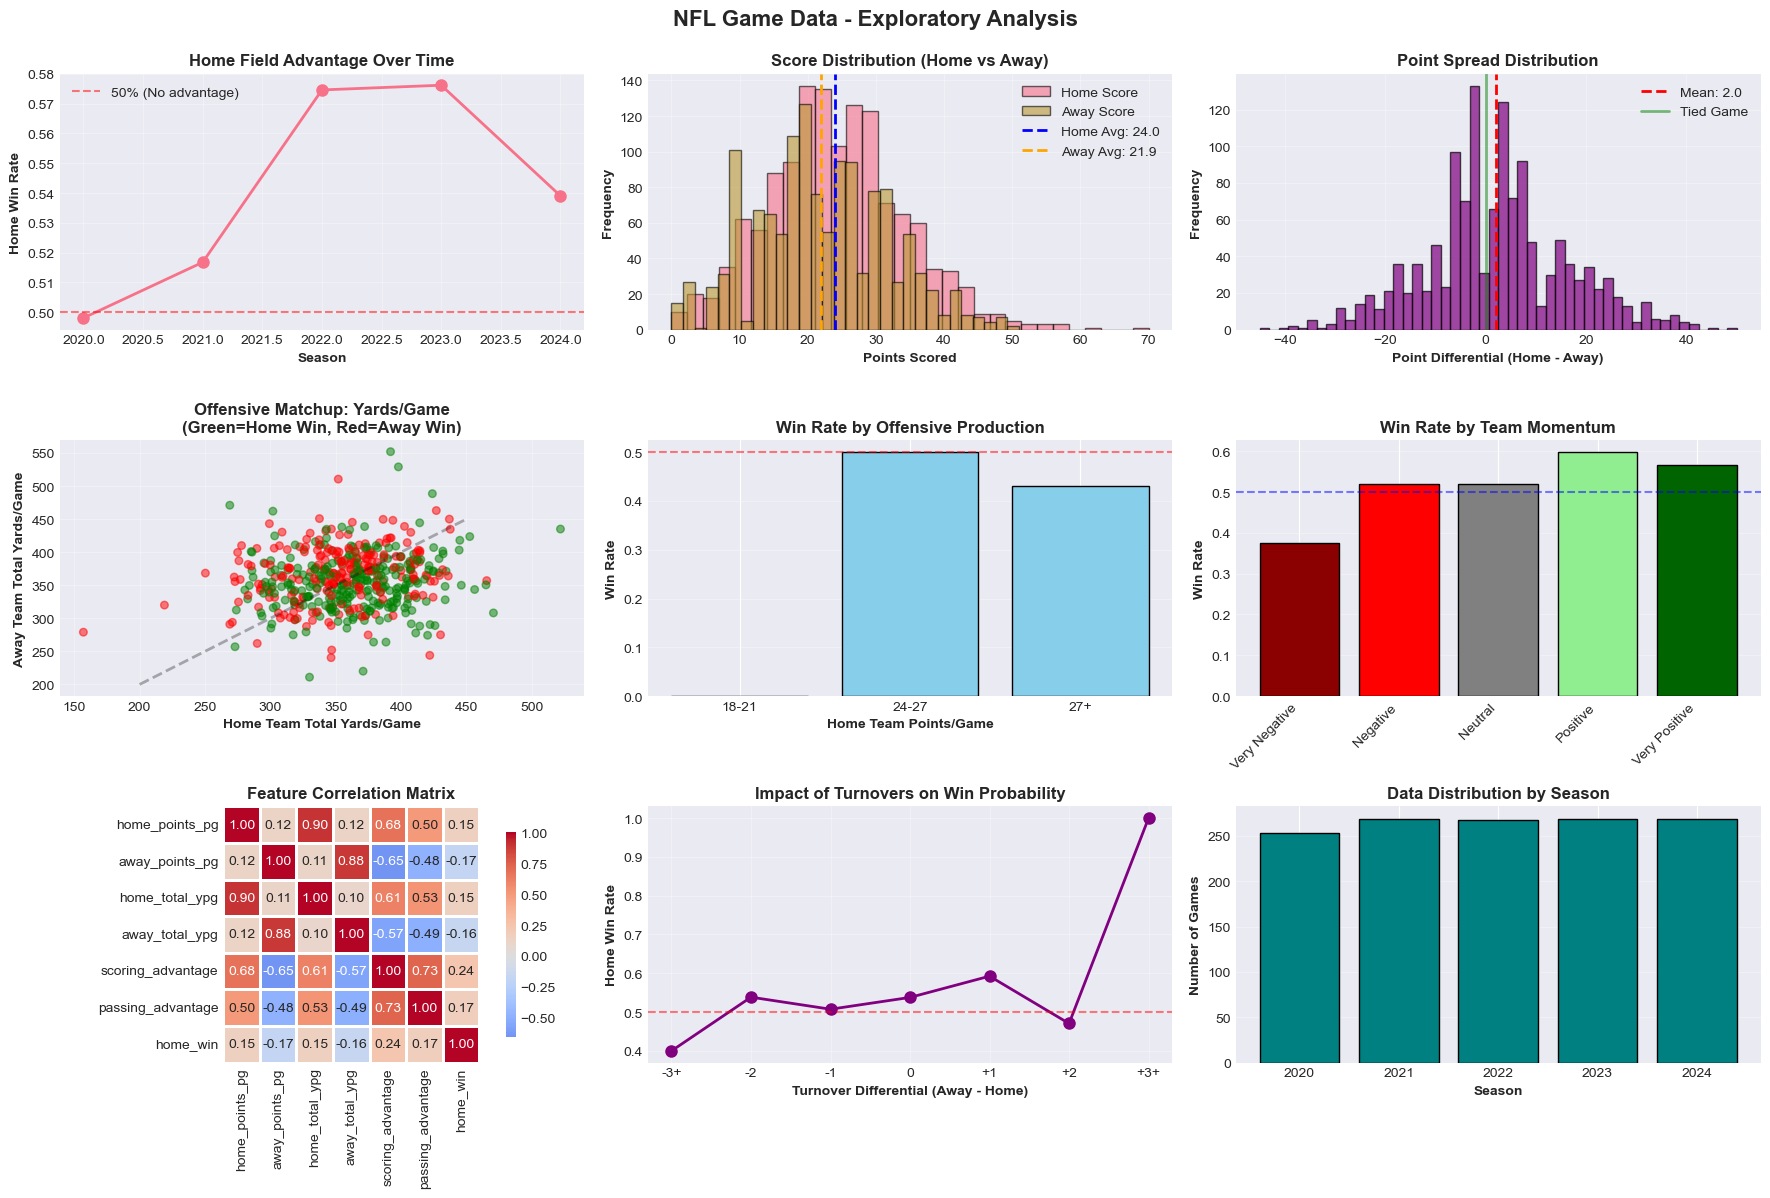


 Key Statistical Insights:
   Average Home Score: 24.0 ± 10.0
   Average Away Score: 21.9 ± 9.8
   Average Point Differential: 2.0 points
   Close Games (<7 pts): 544 (41.0%)
   Blowouts (≥14 pts): 458 (34.5%)

 Exploratory Data Analysis Complete!


In [4]:
# EXPLORATORY DATA ANALYSIS
# Visualize key patterns in the NFL game data to understand relationships and distributions

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plotting style for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Check if we have the processed dataframe from data collection
if 'df' in locals() or 'df' in globals():
    print("EXPLORATORY DATA ANALYSIS")
    print("="*70)
    
    # Basic dataset statistics
    print(f"\n Dataset Overview:")
    print(f"   Total Games: {len(df):,}")
    print(f"   Features: {len([col for col in df.columns if col not in ['home_win', 'home_score', 'away_score', 'game_id']])}")
    print(f"   Date Range: {df['season'].min()}-{df['season'].max()}")
    print(f"   Home Team Wins: {df['home_win'].sum():,} ({df['home_win'].mean():.1%})")
    print(f"   Away Team Wins: {(1-df['home_win']).sum():,} ({(1-df['home_win']).mean():.1%})")
    
    # Create comprehensive visualization figure
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle('NFL Game Data - Exploratory Analysis', fontsize=16, fontweight='bold', y=0.995)
    
    # Plot 1: Home Field Advantage - Win Rate by Season
    ax1 = plt.subplot(3, 3, 1)
    home_win_by_season = df.groupby('season')['home_win'].mean()
    ax1.plot(home_win_by_season.index, home_win_by_season.values, marker='o', linewidth=2, markersize=8)
    ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% (No advantage)')
    ax1.set_xlabel('Season', fontweight='bold')
    ax1.set_ylabel('Home Win Rate', fontweight='bold')
    ax1.set_title('Home Field Advantage Over Time', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Score Distribution
    ax2 = plt.subplot(3, 3, 2)
    ax2.hist(df['home_score'], bins=30, alpha=0.6, label='Home Score', edgecolor='black')
    ax2.hist(df['away_score'], bins=30, alpha=0.6, label='Away Score', edgecolor='black')
    ax2.axvline(x=df['home_score'].mean(), color='blue', linestyle='--', linewidth=2, label=f"Home Avg: {df['home_score'].mean():.1f}")
    ax2.axvline(x=df['away_score'].mean(), color='orange', linestyle='--', linewidth=2, label=f"Away Avg: {df['away_score'].mean():.1f}")
    ax2.set_xlabel('Points Scored', fontweight='bold')
    ax2.set_ylabel('Frequency', fontweight='bold')
    ax2.set_title('Score Distribution (Home vs Away)', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Point Spread Distribution
    ax3 = plt.subplot(3, 3, 3)
    point_spread = df['home_score'] - df['away_score']
    ax3.hist(point_spread, bins=50, edgecolor='black', alpha=0.7, color='purple')
    ax3.axvline(x=point_spread.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {point_spread.mean():.1f}')
    ax3.axvline(x=0, color='green', linestyle='-', linewidth=2, alpha=0.5, label='Tied Game')
    ax3.set_xlabel('Point Differential (Home - Away)', fontweight='bold')
    ax3.set_ylabel('Frequency', fontweight='bold')
    ax3.set_title('Point Spread Distribution', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Offensive vs Defensive Yards (scatter)
    ax4 = plt.subplot(3, 3, 4)
    # Sample data to avoid overplotting
    sample_size = min(500, len(df))
    sample_df = df.sample(n=sample_size, random_state=42)
    colors = ['green' if w == 1 else 'red' for w in sample_df['home_win']]
    ax4.scatter(sample_df['home_total_ypg'], sample_df['away_total_ypg'], 
               c=colors, alpha=0.5, s=30)
    ax4.plot([200, 450], [200, 450], 'k--', alpha=0.3, linewidth=2)  # Diagonal line
    ax4.set_xlabel('Home Team Total Yards/Game', fontweight='bold')
    ax4.set_ylabel('Away Team Total Yards/Game', fontweight='bold')
    ax4.set_title('Offensive Matchup: Yards/Game\n(Green=Home Win, Red=Away Win)', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Points Per Game vs Win Rate
    ax5 = plt.subplot(3, 3, 5)
    # Bin teams by points scored
    bins = [0, 18, 21, 24, 27, 50]
    labels = ['<18', '18-21', '21-24', '24-27', '27+']
    df['ppg_bin'] = pd.cut(df['home_points_pg'], bins=bins, labels=labels)
    win_rate_by_ppg = df.groupby('ppg_bin', observed=True)['home_win'].mean()
    ax5.bar(range(len(win_rate_by_ppg)), win_rate_by_ppg.values, color='skyblue', edgecolor='black')
    ax5.set_xticks(range(len(win_rate_by_ppg)))
    ax5.set_xticklabels(win_rate_by_ppg.index, rotation=0)
    ax5.set_xlabel('Home Team Points/Game', fontweight='bold')
    ax5.set_ylabel('Win Rate', fontweight='bold')
    ax5.set_title('Win Rate by Offensive Production', fontweight='bold')
    ax5.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Plot 6: Recent Form Impact (Momentum)
    ax6 = plt.subplot(3, 3, 6)
    if 'home_points_trend' in df.columns:
        # Bin by momentum/trend
        momentum_bins = pd.cut(df['home_points_trend'], bins=5, labels=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
        win_rate_by_momentum = df.groupby(momentum_bins, observed=True)['home_win'].mean()
        ax6.bar(range(len(win_rate_by_momentum)), win_rate_by_momentum.values, 
               color=['darkred', 'red', 'gray', 'lightgreen', 'darkgreen'], edgecolor='black')
        ax6.set_xticks(range(len(win_rate_by_momentum)))
        ax6.set_xticklabels(win_rate_by_momentum.index, rotation=45, ha='right')
        ax6.set_ylabel('Win Rate', fontweight='bold')
        ax6.set_title('Win Rate by Team Momentum', fontweight='bold')
        ax6.axhline(y=0.5, color='blue', linestyle='--', alpha=0.5)
        ax6.grid(True, alpha=0.3, axis='y')
    
    # Plot 7: Feature Correlation Heatmap (top features)
    ax7 = plt.subplot(3, 3, 7)
    # Select key features for correlation
    key_features = ['home_points_pg', 'away_points_pg', 'home_total_ypg', 'away_total_ypg', 
                   'scoring_advantage', 'passing_advantage', 'home_win']
    available_features = [f for f in key_features if f in df.columns]
    if len(available_features) > 2:
        corr_matrix = df[available_features].corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                   square=True, linewidths=1, ax=ax7, cbar_kws={'shrink': 0.8})
        ax7.set_title('Feature Correlation Matrix', fontweight='bold')
    else:
        ax7.text(0.5, 0.5, 'Insufficient features\nfor correlation plot', 
                ha='center', va='center', fontsize=12)
        ax7.axis('off')
    
    # Plot 8: Turnover Impact on Win Rate
    ax8 = plt.subplot(3, 3, 8)
    if 'home_turnovers_pg' in df.columns and 'away_turnovers_pg' in df.columns:
        turnover_diff = df['away_turnovers_pg'] - df['home_turnovers_pg']
        turnover_bins = pd.cut(turnover_diff, bins=7, labels=['-3+', '-2', '-1', '0', '+1', '+2', '+3+'])
        win_rate_by_to = df.groupby(turnover_bins, observed=True)['home_win'].mean()
        ax8.plot(range(len(win_rate_by_to)), win_rate_by_to.values, marker='o', linewidth=2, markersize=8, color='purple')
        ax8.set_xticks(range(len(win_rate_by_to)))
        ax8.set_xticklabels(win_rate_by_to.index, rotation=0)
        ax8.set_xlabel('Turnover Differential (Away - Home)', fontweight='bold')
        ax8.set_ylabel('Home Win Rate', fontweight='bold')
        ax8.set_title('Impact of Turnovers on Win Probability', fontweight='bold')
        ax8.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
        ax8.grid(True, alpha=0.3)
    
    # Plot 9: Games Per Season
    ax9 = plt.subplot(3, 3, 9)
    games_per_season = df['season'].value_counts().sort_index()
    ax9.bar(games_per_season.index, games_per_season.values, color='teal', edgecolor='black')
    ax9.set_xlabel('Season', fontweight='bold')
    ax9.set_ylabel('Number of Games', fontweight='bold')
    ax9.set_title('Data Distribution by Season', fontweight='bold')
    ax9.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summaries
    print(f"\n Key Statistical Insights:")
    print(f"   Average Home Score: {df['home_score'].mean():.1f} ± {df['home_score'].std():.1f}")
    print(f"   Average Away Score: {df['away_score'].mean():.1f} ± {df['away_score'].std():.1f}")
    print(f"   Average Point Differential: {point_spread.mean():.1f} points")
    print(f"   Close Games (<7 pts): {(abs(point_spread) < 7).sum():,} ({(abs(point_spread) < 7).mean():.1%})")
    print(f"   Blowouts (≥14 pts): {(abs(point_spread) >= 14).sum():,} ({(abs(point_spread) >= 14).mean():.1%})")
    
    print(f"\n Exploratory Data Analysis Complete!")
    
else:
    print("  Dataset 'df' not found. Please run the data collection cell first.")


In [5]:
# NFL SPREAD PREDICTION MODEL
# Enhanced version that predicts point spreads instead of just winners

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

class NFLSpreadPredictor:
    def __init__(self):
        self.spread_model = None
        self.best_features = []
        self.scaler = StandardScaler()
        
    def prepare_spread_data(self, df):
        """Convert winner prediction data to spread prediction data"""
        
        # Create point differential (home_score - away_score)
        df['point_spread'] = df['home_score'] - df['away_score']
        
        print(f"Spread Data Summary:")
        print(f"  Games: {len(df)}")
        print(f"  Average spread: {df['point_spread'].mean():.1f} points")
        print(f"  Spread range: {df['point_spread'].min():.0f} to {df['point_spread'].max():.0f}")
        print(f"  Home team wins: {(df['point_spread'] > 0).sum()} ({(df['point_spread'] > 0).mean():.1%})")
        
        return df
    
    def train_spread_model(self, df, use_existing_features=True):
        """Train regression model to predict point spreads"""
        
        # Prepare spread data
        df = self.prepare_spread_data(df)
        
        # Use existing features or select new ones for regression
        if use_existing_features and hasattr(predictor, 'best_features') and predictor.best_features:
            self.best_features = predictor.best_features
            print(f"Using existing features: {len(self.best_features)} features")
        else:
            # Select features for regression
            feature_cols = [col for col in df.columns 
                           if col not in ['home_win', 'home_score', 'away_score', 'game_id', 'point_spread']]
            self.best_features = feature_cols[:15]  # Use top 15 features
            print(f"Selected {len(self.best_features)} features for spread prediction")
        
        # Prepare data
        X = df[self.best_features].fillna(df[self.best_features].mean())
        y = df['point_spread']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Improved regression models with GradientBoosting
        models = {
            'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42),
            'Linear Regression': LinearRegression(),
            'Gradient Boosting': GradientBoostingRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                loss='quantile',  # Better for spread prediction
                alpha=0.5,  # Median prediction
                subsample=0.8,
                random_state=42
            ),
        }
        
        if HAS_XGB:
            models['XGBoost'] = xgb.XGBRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                reg_alpha=0.5,  # L1 regularization
                reg_lambda=1.0,  # L2 regularization
                random_state=42,
                verbosity=0
            )
        
        print("\nTraining spread prediction models...")
        best_model = None
        best_mae = float('inf')
        
        for name, model in models.items():
            # Use scaled data for linear regression, raw for tree-based
            X_use_train = X_train_scaled if 'Linear' in name else X_train
            X_use_test = X_test_scaled if 'Linear' in name else X_test
            
            # Train model
            model.fit(X_use_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_use_test)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            
            print(f"{name}:")
            print(f"  MAE: {mae:.2f} points")
            print(f"  RMSE: {rmse:.2f} points")
            print(f"  R²: {r2:.3f}")
            
            # Select best model based on MAE
            if mae < best_mae:
                best_mae = mae
                best_model = model
                self.spread_model = model
                print(f"  *** NEW BEST MODEL ***")
            print()
        
        print(f"Best model MAE: {best_mae:.2f} points")
        return self.spread_model
    
    def predict_spreads(self, games_df):
        """Predict point spreads for new games"""
        
        if self.spread_model is None:
            raise ValueError("Spread model not trained yet!")
        
        X = games_df[self.best_features].fillna(games_df[self.best_features].mean())
        
        # Use appropriate scaling based on model type
        if 'Linear' in str(type(self.spread_model)):
            X = self.scaler.transform(X)
        
        # Get spread predictions
        predicted_spreads = self.spread_model.predict(X)
        
        # Create results dataframe
        results = games_df.copy()
        results['predicted_spread'] = predicted_spreads
        
        # Determine winner based on spread
        results['predicted_winner_spread'] = np.where(
            predicted_spreads > 0, 
            results.get('home_team', 'HOME'),  # Home team wins if spread > 0
            results.get('away_team', 'AWAY')   # Away team wins if spread < 0
        )
        
        # IMPROVED: Better confidence calculation based on spread magnitude
        # Confidence increases with spread size (more certain about blowouts)
        # Formula: 0.50 + min(0.45, abs(spread) * 0.025)
        # Results: 0 spread = 50%, 10 pt spread = 75%, 18+ pt spread = 95%
        base_confidence = 0.50
        spread_factor = np.abs(predicted_spreads) * 0.025
        results['spread_confidence'] = np.clip(base_confidence + spread_factor, 0.50, 0.95)
        
        return results

# Initialize spread predictor
spread_predictor = NFLSpreadPredictor()

print("NFL SPREAD PREDICTION MODEL READY!")
print("\nThis model predicts:")
print("  - Point spreads (e.g., Chiefs -7.5)")
print("  - How much teams will win/lose by")
print("  - More detailed game analysis")
print("\nNext: Train the spread model using existing data!")

NFL SPREAD PREDICTION MODEL READY!

This model predicts:
  - Point spreads (e.g., Chiefs -7.5)
  - How much teams will win/lose by
  - More detailed game analysis

Next: Train the spread model using existing data!


In [6]:
# TRAIN THE SPREAD MODEL
print("TRAINING NFL SPREAD PREDICTION MODEL")
print("="*50)

# Check if we have the original data
if 'df' in locals() or 'df' in globals():
    try:
        # Train spread model using existing dataset
        print("Training spread model on historical data...")
        
        spread_model = spread_predictor.train_spread_model(df, use_existing_features=True)
        
        if spread_model is not None:
            print("Spread model trained successfully!")
            print("\nModel can now predict:")
            print("  - Point spreads (e.g., 'Chiefs -7.5')")
            print("  - Victory margins")
            print("  - Game competitiveness")
            
            # Test on a few sample games
            print(f"\nTesting on recent games...")
            test_games = df.tail(3)
            if not test_games.empty:
                spread_results = spread_predictor.predict_spreads(test_games)
                
                print("Sample predictions:")
                for _, game in spread_results.iterrows():
                    home_team = game.get('game_id', 'Unknown').split('_')[-2] if 'game_id' in game else 'HOME'
                    away_team = game.get('game_id', 'Unknown').split('_')[-1] if 'game_id' in game else 'AWAY'
                    spread = game['predicted_spread']
                    actual_spread = game.get('point_spread', 0)
                    
                    if spread > 0:
                        print(f"  {home_team} -{abs(spread):.1f} vs {away_team} (actual: {actual_spread:+.0f})")
                    else:
                        print(f"  {away_team} -{abs(spread):.1f} vs {home_team} (actual: {actual_spread:+.0f})")
        
    except Exception as e:
        print(f"Error training spread model: {e}")
        print("Make sure the original model data is available.")
        
else:
    print("ERROR: No training data found!")
    print("Please run Step 2 first to collect and prepare the data.")

TRAINING NFL SPREAD PREDICTION MODEL
Training spread model on historical data...
Spread Data Summary:
  Games: 1328
  Average spread: 2.0 points
  Spread range: -45 to 50
  Home team wins: 719 (54.1%)
Using existing features: 7 features

Training spread prediction models...
Random Forest:
  MAE: 12.43 points
  RMSE: 15.75 points
  R²: -0.010
  *** NEW BEST MODEL ***

Linear Regression:
  MAE: 11.91 points
  RMSE: 15.25 points
  R²: 0.053
  *** NEW BEST MODEL ***

Gradient Boosting:
  MAE: 12.85 points
  RMSE: 16.24 points
  R²: -0.075

XGBoost:
  MAE: 13.11 points
  RMSE: 16.51 points
  R²: -0.111

Best model MAE: 11.91 points
Spread model trained successfully!

Model can now predict:
  - Point spreads (e.g., 'Chiefs -7.5')
  - Victory margins
  - Game competitiveness

Testing on recent games...
Sample predictions:
  PHI -3.7 vs WAS (actual: +32)
  KC -1.9 vs BUF (actual: +3)
  PHI -7.9 vs KC (actual: +18)


In [7]:
# ENHANCED SPREAD PREDICTION FUNCTION
import re
from datetime import datetime

def predict_multiple_games_with_spreads(predictor, spread_predictor, games_text, season=2025, week=6, show_details=True):
    """
    Predict multiple games with BOTH winner probabilities AND point spreads
    
    Args:
        predictor: Trained NFLGamePredictor instance (for winner predictions)
        spread_predictor: Trained NFLSpreadPredictor instance (for spread predictions)
        games_text: Formatted text with games
        season: Season year
        week: Week number
        show_details: Whether to show detailed output
    
    Returns:
        DataFrame with both winner and spread predictions
    """
    
    if predictor.final_model is None:
        return None
        
    if spread_predictor.spread_model is None:
        return None
    
    # Use existing team mapping from original function
    team_mapping = {
        'TB Buccaneers': 'TB', 'Tampa Bay Buccaneers': 'TB', 'TB': 'TB',
        'ATL Falcons': 'ATL', 'Atlanta Falcons': 'ATL', 'ATL': 'ATL',
        'CIN Bengals': 'CIN', 'Cincinnati Bengals': 'CIN', 'CIN': 'CIN',
        'CLE Browns': 'CLE', 'Cleveland Browns': 'CLE', 'CLE': 'CLE',
        'MIA Dolphins': 'MIA', 'Miami Dolphins': 'MIA', 'MIA': 'MIA',
        'IND Colts': 'IND', 'Indianapolis Colts': 'IND', 'IND': 'IND',
        'CAR Panthers': 'CAR', 'Carolina Panthers': 'CAR', 'CAR': 'CAR',
        'JAX Jaguars': 'JAX', 'Jacksonville Jaguars': 'JAX', 'JAX': 'JAX',
        'LV Raiders': 'LV', 'Las Vegas Raiders': 'LV', 'LV': 'LV',
        'NE Patriots': 'NE', 'New England Patriots': 'NE', 'NE': 'NE',
        'ARI Cardinals': 'ARI', 'Arizona Cardinals': 'ARI', 'ARI': 'ARI',
        'NO Saints': 'NO', 'New Orleans Saints': 'NO', 'NO': 'NO',
        'PIT Steelers': 'PIT', 'Pittsburgh Steelers': 'PIT', 'PIT': 'PIT',
        'NYJ Jets': 'NYJ', 'New York Jets': 'NYJ', 'NYJ': 'NYJ',
        'NYG Giants': 'NYG', 'New York Giants': 'NYG', 'NYG': 'NYG',
        'WAS Commanders': 'WAS', 'Washington Commanders': 'WAS', 'WAS': 'WAS',
        'TEN Titans': 'TEN', 'Tennessee Titans': 'TEN', 'TEN': 'TEN',
        'DEN Broncos': 'DEN', 'Denver Broncos': 'DEN', 'DEN': 'DEN',
        'SF 49ers': 'SF', 'San Francisco 49ers': 'SF', 'SF': 'SF',
        'SEA Seahawks': 'SEA', 'Seattle Seahawks': 'SEA', 'SEA': 'SEA',
        'DET Lions': 'DET', 'Detroit Lions': 'DET', 'DET': 'DET',
        'GB Packers': 'GB', 'Green Bay Packers': 'GB', 'GB': 'GB',
        'HOU Texans': 'HOU', 'Houston Texans': 'HOU', 'HOU': 'HOU',
        'LA Rams': 'LA', 'Los Angeles Rams': 'LA', 'LA': 'LA',
        'LAR Rams': 'LA', 'Los Angeles Rams': 'LA', 'LAR': 'LA',
        'BAL Ravens': 'BAL', 'Baltimore Ravens': 'BAL', 'BAL': 'BAL',
        'BUF Bills': 'BUF', 'Buffalo Bills': 'BUF', 'BUF': 'BUF',
        'KC Chiefs': 'KC', 'Kansas City Chiefs': 'KC', 'KC': 'KC',
        'PHI Eagles': 'PHI', 'Philadelphia Eagles': 'PHI', 'PHI': 'PHI',
        'DAL Cowboys': 'DAL', 'Dallas Cowboys': 'DAL', 'DAL': 'DAL',
        'MIN Vikings': 'MIN', 'Minnesota Vikings': 'MIN', 'MIN': 'MIN',
        'CHI Bears': 'CHI', 'Chicago Bears': 'CHI', 'CHI': 'CHI',
        'LAC Chargers': 'LAC', 'Los Angeles Chargers': 'LAC', 'LAC': 'LAC'
    }
    
    # Parse games
    game_pattern = r'\(Away\)\s+(.*?)\s+vs\.\s+\(Home\)\s+(.*)'
    matches = re.findall(game_pattern, games_text, re.IGNORECASE)
    
    if not matches:
        return None
    
    # Get team features
    try:
        team_features = predictor.create_team_features(weekly_data, 2025, week, schedule_data)
        if not team_features:
            team_features = predictor.create_team_features(weekly_data, 2024, 19, schedule_data)
            data_source = "2024 season-end"
        else:
            data_source = f"2025 Week {week-1}"
            
        if not team_features:
            return None
            
    except Exception as e:
        return None
    
    all_predictions = []
    successful_predictions = 0
    
    for i, (away_full, home_full) in enumerate(matches, 1):
        away_full = away_full.strip()
        home_full = home_full.strip()
        
        # Map to abbreviations
        away_team = team_mapping.get(away_full, away_full.split()[-1] if away_full.split() else away_full)
        home_team = team_mapping.get(home_full, home_full.split()[-1] if home_full.split() else home_full)
        
        away_team = away_team.strip().upper()
        home_team = home_team.strip().upper()
        
        try:
            # Check if teams exist
            if away_team not in team_features or home_team not in team_features:
                continue
            
            # Create game features
            game_features = predictor.create_game_features(
                home_team, away_team, team_features,
                season, week, is_playoff=False, is_neutral=False
            )
            
            if game_features is None:
                continue
            
            game_df = pd.DataFrame([game_features])
            
            # Get BOTH winner and spread predictions
            winner_result = predictor.predict_games(game_df)
            spread_result = spread_predictor.predict_spreads(game_df)
            
            # Extract results
            home_win_prob = winner_result['home_win_prob'].iloc[0]
            predicted_home_win = winner_result['predicted_home_win'].iloc[0]
            predicted_spread = spread_result['predicted_spread'].iloc[0]
            
            # CRITICAL: Ensure spread and winner are consistent
            # The team with the negative spread MUST be the predicted winner
            # Calculate confidence based on spread: Win Probability ≈ 50% + (spread × 2.5%)
            spread_magnitude = abs(predicted_spread)
            spread_based_confidence = 0.50 + (spread_magnitude * 0.025)
            spread_based_confidence = min(spread_based_confidence, 0.95)  
            
            if predicted_spread > 0:
                # Home team favored (positive spread means home team wins)
                spread_display = f"{home_team} -{abs(predicted_spread):.1f}"
                favored_team = home_team
                winner = home_team  # Winner must match the favored team
                confidence = spread_based_confidence
            else:
                # Away team favored (negative spread means away team wins)
                spread_display = f"{away_team} -{abs(predicted_spread):.1f}"
                favored_team = away_team
                winner = away_team  # Winner must match the favored team
                confidence = spread_based_confidence
            
            # Store comprehensive prediction
            prediction_data = {
                'game_num': i,
                'away_team': away_team,
                'home_team': home_team,
                'matchup': f"{away_team} @ {home_team}",
                'predicted_winner': winner,
                'confidence': confidence,
                'home_win_prob': home_win_prob,
                'away_win_prob': 1 - home_win_prob,
                'predicted_spread': predicted_spread,
                'spread_display': spread_display,
                'favored_team': favored_team,
                'spread_magnitude': abs(predicted_spread)
            }
            
            all_predictions.append(prediction_data)
            successful_predictions += 1
            
        except Exception as e:
            continue
    
    if not all_predictions:
        return None
    
    # Create results DataFrame
    predictions_df = pd.DataFrame(all_predictions)
    
    return predictions_df

print("ENHANCED SPREAD PREDICTION FUNCTION READY!")
print("\nThis function provides:")
print("  - Winner predictions with confidence")
print("  - Point spread predictions")
print("  - Game competitiveness analysis")
print("  - Betting-focused insights")

ENHANCED SPREAD PREDICTION FUNCTION READY!

This function provides:
  - Winner predictions with confidence
  - Point spread predictions
  - Game competitiveness analysis
  - Betting-focused insights


In [8]:
# EXECUTE WEEK 14 SPREAD PREDICTIONS
print("EXECUTING NFL WEEK 14 SPREAD PREDICTIONS")
print("="*60)

# Week 14 Complete Schedule (December 2025)
week14_games = """
(Away) Dallas Cowboys vs. (Home) Detroit Lions
(Away) Seattle Seahawks vs. (Home) Atlanta Falcons
(Away) Cincinnati Bengals vs. (Home) Buffalo Bills
(Away) Tennessee Titans vs. (Home) Cleveland Browns
(Away) Washington Commanders vs. (Home) Minnesota Vikings
(Away) Miami Dolphins vs. (Home) New York Jets
(Away) New Orleans Saints vs. (Home) Tampa Bay Buccaneers
(Away) Indianapolis Colts vs. (Home) Jacksonville Jaguars
(Away) Pittsburgh Steelers vs. (Home) Baltimore Ravens
(Away) Denver Broncos vs. (Home) Las Vegas Raiders
(Away) Chicago Bears vs. (Home) Green Bay Packers
(Away) Los Angeles Rams vs. (Home) Arizona Cardinals
(Away) Houston Texans vs. (Home) Kansas City Chiefs
(Away) Philadelphia Eagles vs. (Home) Los Angeles Chargers
"""

# Check if both models are trained
if ('predictor' in locals() and hasattr(predictor, 'final_model') and predictor.final_model is not None and
    'spread_predictor' in locals() and hasattr(spread_predictor, 'spread_model') and spread_predictor.spread_model is not None):
    
    print("Both models are trained and ready!")
    print("Generating comprehensive predictions with spreads...")
    print()

    # Run enhanced predictions with spreads
    week14_spread_results = predict_multiple_games_with_spreads(
        predictor, spread_predictor, week14_games, 
        season=2025, week=14, show_details=False
    )

    if week14_spread_results is not None:
        print(f"\n\nWEEK 14 PREDICTIONS")
        print("=" * 70)
        print(f"{'MATCHUP':<20} {'SPREAD':<15} {'WINNER':<12} {'CONFIDENCE':<12}")
        print("-" * 70)

        # Week 14 game schedule
        game_schedule = {
            'DAL @ DET': ('Thursday', '7:00 PM ET'),
            'SEA @ ATL': ('Sunday', '1:00 PM ET'),
            'CIN @ BUF': ('Sunday', '1:00 PM ET'),
            'TEN @ CLE': ('Sunday', '1:00 PM ET'),
            'WSH @ MIN': ('Sunday', '1:00 PM ET'),
            'MIA @ NYJ': ('Sunday', '1:00 PM ET'),
            'NO @ TB': ('Sunday', '1:00 PM ET'),
            'IND @ JAX': ('Sunday', '1:00 PM ET'),
            'PIT @ BAL': ('Sunday', '1:00 PM ET'),
            'DEN @ LV': ('Sunday', '4:05 PM ET'),
            'CHI @ GB': ('Sunday', '4:25 PM ET'),
            'LA @ ARI': ('Sunday', '4:25 PM ET'),
            'HOU @ KC': ('Sunday', '8:20 PM ET'),
            'PHI @ LAC': ('Monday', '8:15 PM ET')
        }

        time_order = [
            'DAL @ DET',
            'SEA @ ATL', 'CIN @ BUF', 'TEN @ CLE', 'WSH @ MIN', 'MIA @ NYJ', 'NO @ TB', 'IND @ JAX', 'PIT @ BAL',
            'DEN @ LV',
            'CHI @ GB', 'LA @ ARI',
            'HOU @ KC',
            'PHI @ LAC'
        ]
        
        # Team name mapping for display
        team_names = {
            'WAS': 'Commanders', 'GB': 'Packers', 'NYG': 'Giants', 'DAL': 'Cowboys',
            'SEA': 'Seahawks', 'PIT': 'Steelers', 'LA': 'Rams', 'TEN': 'Titans',
            'BUF': 'Bills', 'NYJ': 'Jets', 'NE': 'Patriots', 'MIA': 'Dolphins',
            'JAX': 'Jaguars', 'CIN': 'Bengals', 'SF': '49ers', 'NO': 'Saints',
            'CLE': 'Browns', 'BAL': 'Ravens', 'CHI': 'Bears', 'DET': 'Lions',
            'DEN': 'Broncos', 'IND': 'Colts', 'CAR': 'Panthers', 'ARI': 'Cardinals',
            'PHI': 'Eagles', 'KC': 'Chiefs', 'ATL': 'Falcons', 'MIN': 'Vikings',
            'TB': 'Buccaneers', 'HOU': 'Texans', 'LAC': 'Chargers', 'LV': 'Raiders'
        }
        
        # Display results with spreads
        for matchup in time_order:
            game_row = week14_spread_results[week14_spread_results['matchup'] == matchup]
            if not game_row.empty:
                game = game_row.iloc[0]
                winner_abbr = game['predicted_winner']
                winner_name = team_names.get(winner_abbr, winner_abbr)
                spread_display = game['spread_display']
                
                print(f"{game['matchup']:<20} {spread_display:<15} {winner_name:<12} {game['confidence']:.1%}")
        
        print("-" * 70)
        print(f"Total Games: {len(week14_spread_results)} | Avg Spread: {week14_spread_results['spread_magnitude'].mean():.1f} pts")
        
        # Additional insights
        close_games = week14_spread_results[week14_spread_results['spread_magnitude'] <= 3.5]
        blowouts = week14_spread_results[week14_spread_results['spread_magnitude'] >= 10.0]
        print(f"\nGAME ANALYSIS:")
        print(f"  Close games (≤3.5 pts): {len(close_games)}")
        print(f"  Potential blowouts (≥10 pts): {len(blowouts)}")
        print(f"  Home teams favored: {(week14_spread_results['predicted_spread'] > 0).sum()}")
        print(f"  Away teams favored: {(week14_spread_results['predicted_spread'] < 0).sum()}")

        print(f"\nResults saved to 'week14_spread_results' variable")

    else:
        print("ERROR: Failed to generate spread predictions")
        
else:
    print("ERROR: Models not trained yet!")
    print("\nPlease run:")
    print("1. Step 2 to train the winner prediction model")
    print("2. Step 8 to train the spread prediction model")

EXECUTING NFL WEEK 14 SPREAD PREDICTIONS
Both models are trained and ready!
Generating comprehensive predictions with spreads...



WEEK 14 PREDICTIONS
MATCHUP              SPREAD          WINNER       CONFIDENCE  
----------------------------------------------------------------------
DAL @ DET            DET -11.0       Lions        77.6%
SEA @ ATL            ATL -6.0        Falcons      65.1%
CIN @ BUF            BUF -3.6        Bills        59.0%
TEN @ CLE            CLE -4.1        Browns       60.1%
MIA @ NYJ            NYJ -5.3        Jets         63.1%
NO @ TB              TB -9.5         Buccaneers   73.8%
IND @ JAX            JAX -3.5        Jaguars      58.8%
PIT @ BAL            BAL -10.4       Ravens       75.9%
DEN @ LV             LV -2.9         Raiders      57.2%
CHI @ GB             GB -8.8         Packers      71.9%
LA @ ARI             ARI -6.5        Cardinals    66.3%
HOU @ KC             KC -5.9         Chiefs       64.7%
PHI @ LAC            LAC -3.9        Charg

In [9]:
# ===== CONFIGURATION (Update these for each week) =====
WEEK_NUMBER = 14
SEASON = 2025

# ===== AUTOMATED RESULT FETCHING =====
def fetch_actual_results(predictions_df, season, week):
    """
    Automatically fetch actual game results from nfl_data_py
    No more manual data entry needed!
    """
    try:
        # Try to use already-loaded schedule_data if available (faster)
        if 'schedule_data' in globals() and schedule_data is not None:
            print(f"Using existing schedule data for {season} Week {week}...")
            current_schedule = schedule_data.copy()
            # Filter for the target season
            current_schedule = current_schedule[current_schedule['season'] == season]
            if not current_schedule.empty:
                print(f"Found {len(current_schedule)} games in existing data for {season}")
            else:
                # Fall back to downloading fresh data
                print(f"Existing data doesn't have {season}, downloading fresh data...")
                current_schedule = nfl.import_schedules([season])
        else:
            # Import fresh schedule data for the target week
            print(f"Fetching schedule data for {season} Week {week}...")
            current_schedule = nfl.import_schedules([season])
        
        if current_schedule.empty:
            print(f"Warning: No schedule data found for {season}. Trying previous season...")
            # Try previous season as fallback
            current_schedule = nfl.import_schedules([season - 1])
            if current_schedule.empty:
                print(f"Error: No schedule data available for {season} or {season - 1}")
                return None
        
        # Filter for the specific week
        week_games = current_schedule[
            (current_schedule['season'] == season) & 
            (current_schedule['week'] == week)
        ].copy()
        
        if week_games.empty:
            print(f"Warning: No games found for {season} Week {week}")
            if 'week' in current_schedule.columns:
                available_weeks = sorted([w for w in current_schedule['week'].unique() if pd.notna(w)])
                print(f"Available weeks in data: {available_weeks}")
            return None
        
        print(f"Found {len(week_games)} scheduled games for Week {week}")
        
        # Ensure team columns are strings for matching
        if 'away_team' in week_games.columns:
            week_games['away_team'] = week_games['away_team'].astype(str).str.strip()
        if 'home_team' in week_games.columns:
            week_games['home_team'] = week_games['home_team'].astype(str).str.strip()
        
        actual_results = {}
        games_found = 0
        games_played = 0
        games_missing = []
        
        # Process each prediction to find actual results
        for _, pred_row in predictions_df.iterrows():
            matchup = pred_row['matchup']
            away_team = str(pred_row['away_team']).strip().upper()
            home_team = str(pred_row['home_team']).strip().upper()
            
            # Find corresponding game in schedule (case-insensitive matching)
            game_row = week_games[
                (week_games['away_team'].str.upper() == away_team) & 
                (week_games['home_team'].str.upper() == home_team)
            ]
            
            if not game_row.empty:
                game = game_row.iloc[0]
                games_found += 1
                
                # Use direct column access instead of .get() for pandas Series
                try:
                    home_score = game['home_score'] if 'home_score' in game.index else None
                    away_score = game['away_score'] if 'away_score' in game.index else None
                except (KeyError, AttributeError):
                    # Fallback to .get() if direct access fails
                    home_score = game.get('home_score', None) if hasattr(game, 'get') else None
                    away_score = game.get('away_score', None) if hasattr(game, 'get') else None
                
                # Check if scores are available and valid
                if pd.notna(home_score) and pd.notna(away_score):
                    try:
                        home_score = float(home_score)
                        away_score = float(away_score)
                        
                        # Game completed - extract results
                        winner = home_team if home_score > away_score else away_team
                        
                        # Get additional game info safely
                        game_id = game['game_id'] if 'game_id' in game.index else ''
                        gameday = game['gameday'] if 'gameday' in game.index else ''
                        
                        actual_results[matchup] = {
                            'winner': winner,
                            'home_score': int(home_score),
                            'away_score': int(away_score),
                            'game_id': game_id,
                            'gameday': gameday
                        }
                        games_played += 1
                    except (ValueError, TypeError) as e:
                        print(f"Warning: Could not parse scores for {matchup}: {e}")
                        games_missing.append(matchup)
                else:
                    games_missing.append(matchup)
            else:
                games_missing.append(matchup)
        
        print(f"\nResults Summary:")
        print(f"  Games found in schedule: {games_found}/{len(predictions_df)}")
        print(f"  Games with completed scores: {games_played}/{len(predictions_df)}")
        
        if games_missing:
            print(f"\nGames not yet completed or not found:")
            for gm in games_missing[:5]:  # Show first 5
                print(f"  - {gm}")
            if len(games_missing) > 5:
                print(f"  ... and {len(games_missing) - 5} more")
        
        if games_played == 0:
            print(f"\nNo completed games found for Week {week}, {season}")
            print("Games may not have been played yet, or scores are not available.")
            return None
            
        return actual_results
        
    except Exception as e:
        import traceback
        print(f"Error fetching results: {e}")
        print(f"Error type: {type(e).__name__}")
        print("\nFull traceback:")
        traceback.print_exc()
        return None

def quick_results_check(week_num=None, season_year=None):
    """
    One-click function to check results for any week
    """
    # Use config values if not specified
    if week_num is None:
        week_num = WEEK_NUMBER
    if season_year is None:
        season_year = SEASON
    
    # Find the predictions variable for this week
    predictions_var = f'week{week_num}_spread_results'
    
    if predictions_var in locals() or predictions_var in globals():
        try:
            # Get the predictions dataframe
            if predictions_var in locals():
                predictions_df = locals()[predictions_var]
            else:
                predictions_df = globals()[predictions_var]
            
            # Fetch actual results automatically
            actual_results = fetch_actual_results(predictions_df, season_year, week_num)
            
            if actual_results:
                # Run the analysis with fetched results
                results = analyze_week(week_num, season_year, predictions_df, actual_results)
                
                # Save to global variable
                globals()[f'week{week_num}_final_results'] = results
                globals()[f'week{week_num}_actual_results'] = actual_results
                
                return results
            else:
                print("No results available yet - games may not be completed.")
                return None
                
        except Exception as e:
            print(f"Error: {e}")
            return None
    else:
        print(f"'{predictions_var}' not found - run predictions first")
        return None

# Smart result fetcher - tries auto-fetch, falls back gracefully
def get_week_results(predictions_df=None, manual_results=None):
    """
    Smart function that tries automatic fetching first, 
    then falls back to manual results if provided
    """
    if predictions_df is None:
        # Try to find week1_results
        if 'week1_results' in locals():
            predictions_df = week1_results
        elif 'week1_results' in globals():
            predictions_df = globals()['week1_results']
        else:
            print("No predictions found. Run predictions first.")
            return None
    
    # Try automatic fetching first
    actual_results = fetch_actual_results(predictions_df, SEASON, WEEK_NUMBER)
    
    if actual_results:
        return actual_results
    elif manual_results:
        return manual_results
    else:
        print("No results available - games may not be completed yet")
        return None

print("Result system ready. Use: quick_results_check()")

# ===== AUTOMATED ANALYSIS CODE (No changes needed below) =====

def analyze_week(week_num, season_year, predictions_df, actuals):
    """
    Universal function to analyze any week's predictions vs actual results
    """
    print("=" * 95)
    print(f"{' ' * 25}NFL WEEK {week_num} {season_year} - FINAL RESULTS")
    print("=" * 95)
    
    # Build comparison
    results = {}
    for matchup, actual in actuals.items():
        pred_row = predictions_df[predictions_df['matchup'] == matchup]
        if not pred_row.empty:
            pred = pred_row.iloc[0]['predicted_winner']
            conf = pred_row.iloc[0]['confidence'] * 100
            results[matchup] = {
                'predicted': pred,
                'actual': actual['winner'],
                'score': f"{actual['away_score']}-{actual['home_score']}",
                'correct': pred == actual['winner'],
                'confidence': conf
            }
    
    # Display table
    print(f"\n{'GAME':<20} {'PREDICTED':<12} {'ACTUAL':<12} {'SCORE':<12} {'RESULT':<10}")
    print("-" * 95)
    
    correct = sum(1 for r in results.values() if r['correct'])
    total = len(results)
    
    for matchup, result in results.items():
        status = "CORRECT" if result['correct'] else "WRONG"
        print(f"{matchup:<20} {result['predicted']:<12} {result['actual']:<12} {result['score']:<12} {status:<10}")
    
    # Summary
    accuracy = (correct / total * 100) if total > 0 else 0
    print("-" * 95)
    print(f"\nOVERALL ACCURACY: {correct}/{total} = {accuracy:.1f}%\n")
    
    # Breakdown
    correct_games = [(m, r) for m, r in results.items() if r['correct']]
    incorrect_games = [(m, r) for m, r in results.items() if not r['correct']]
    
    print("=" * 95)
    print(f"CORRECT PREDICTIONS ({len(correct_games)}/{total}):")
    print("=" * 95)
    for matchup, result in correct_games:
        print(f"  {matchup:<20} {result['actual']:<5} | Score: {result['score']:<10} | Confidence: {result['confidence']:.1f}%")
    
    print("\n" + "=" * 95)
    print(f"INCORRECT PREDICTIONS ({len(incorrect_games)}/{total}):")
    print("=" * 95)
    for matchup, result in incorrect_games:
        print(f"  {matchup:<20} Predicted: {result['predicted']:<5} | Actual: {result['actual']:<5} | Score: {result['score']}")
    
    # High confidence analysis
    high_conf = {m: r for m, r in results.items() if r['confidence'] > 65}
    if high_conf:
        hc_correct = sum(1 for r in high_conf.values() if r['correct'])
        hc_accuracy = (hc_correct / len(high_conf) * 100)
        print("\n" + "=" * 95)
        print(f"HIGH CONFIDENCE PICKS (>65%): {hc_correct}/{len(high_conf)} = {hc_accuracy:.1f}%")
        print("=" * 95)
        for matchup, result in high_conf.items():
            status = "Correct" if result['correct'] else "Incorrect"
            print(f"{status} {matchup:<20} {result['predicted']:<5} ({result['confidence']:.1f}%) → Actual: {result['actual']}")
    
    print(f"\nResults saved to 'week{week_num}_final_results'")
    return results

# ===== SEAMLESS EXECUTION =====
# Auto-run analysis if predictions exist
if f'week{WEEK_NUMBER}_spread_results' in globals():
    quick_results_check()
else:
    print("Run predictions first, then return here for results analysis.")


Result system ready. Use: quick_results_check()
Using existing schedule data for 2025 Week 14...
Found 272 games in existing data for 2025
Found 14 scheduled games for Week 14

Results Summary:
  Games found in schedule: 14/14
  Games with completed scores: 12/14

Games not yet completed or not found:
  - HOU @ KC
  - PHI @ LAC
                         NFL WEEK 14 2025 - FINAL RESULTS

GAME                 PREDICTED    ACTUAL       SCORE        RESULT    
-----------------------------------------------------------------------------------------------
DAL @ DET            DET          DET          30-44        CORRECT   
SEA @ ATL            ATL          SEA          37-9         WRONG     
CIN @ BUF            BUF          BUF          34-39        CORRECT   
TEN @ CLE            CLE          TEN          31-29        WRONG     
WAS @ MIN            MIN          MIN          0-31         CORRECT   
MIA @ NYJ            NYJ          MIA          34-10        WRONG     
NO @ TB           

In [10]:
# Save Week 14 predictions to CSV for Plot.ipynb
# This allows Plot.ipynb to load predictions even in different Jupyter sessions

if 'week14_spread_results' in globals() and week14_spread_results is not None:
    import os
    # Save in the Week14 directory so Plot.ipynb can find it
    csv_path = os.path.join("week14_predictions.csv")
    week14_spread_results.to_csv(csv_path, index=False)
    print(f"Saved Week 14 predictions to {os.path.abspath(csv_path)}")
    print(f"  Total predictions: {len(week14_spread_results)}")
    print(f"  This file can now be loaded by Plot.ipynb automatically!")
else:
    print("week14_spread_results not found. Run the prediction cell first.")


Saved Week 14 predictions to /Users/akulaggarwal/Desktop/NFL Performance Prediction/Week14/week14_predictions.csv
  Total predictions: 14
  This file can now be loaded by Plot.ipynb automatically!


MODEL PERFORMANCE RESULTS


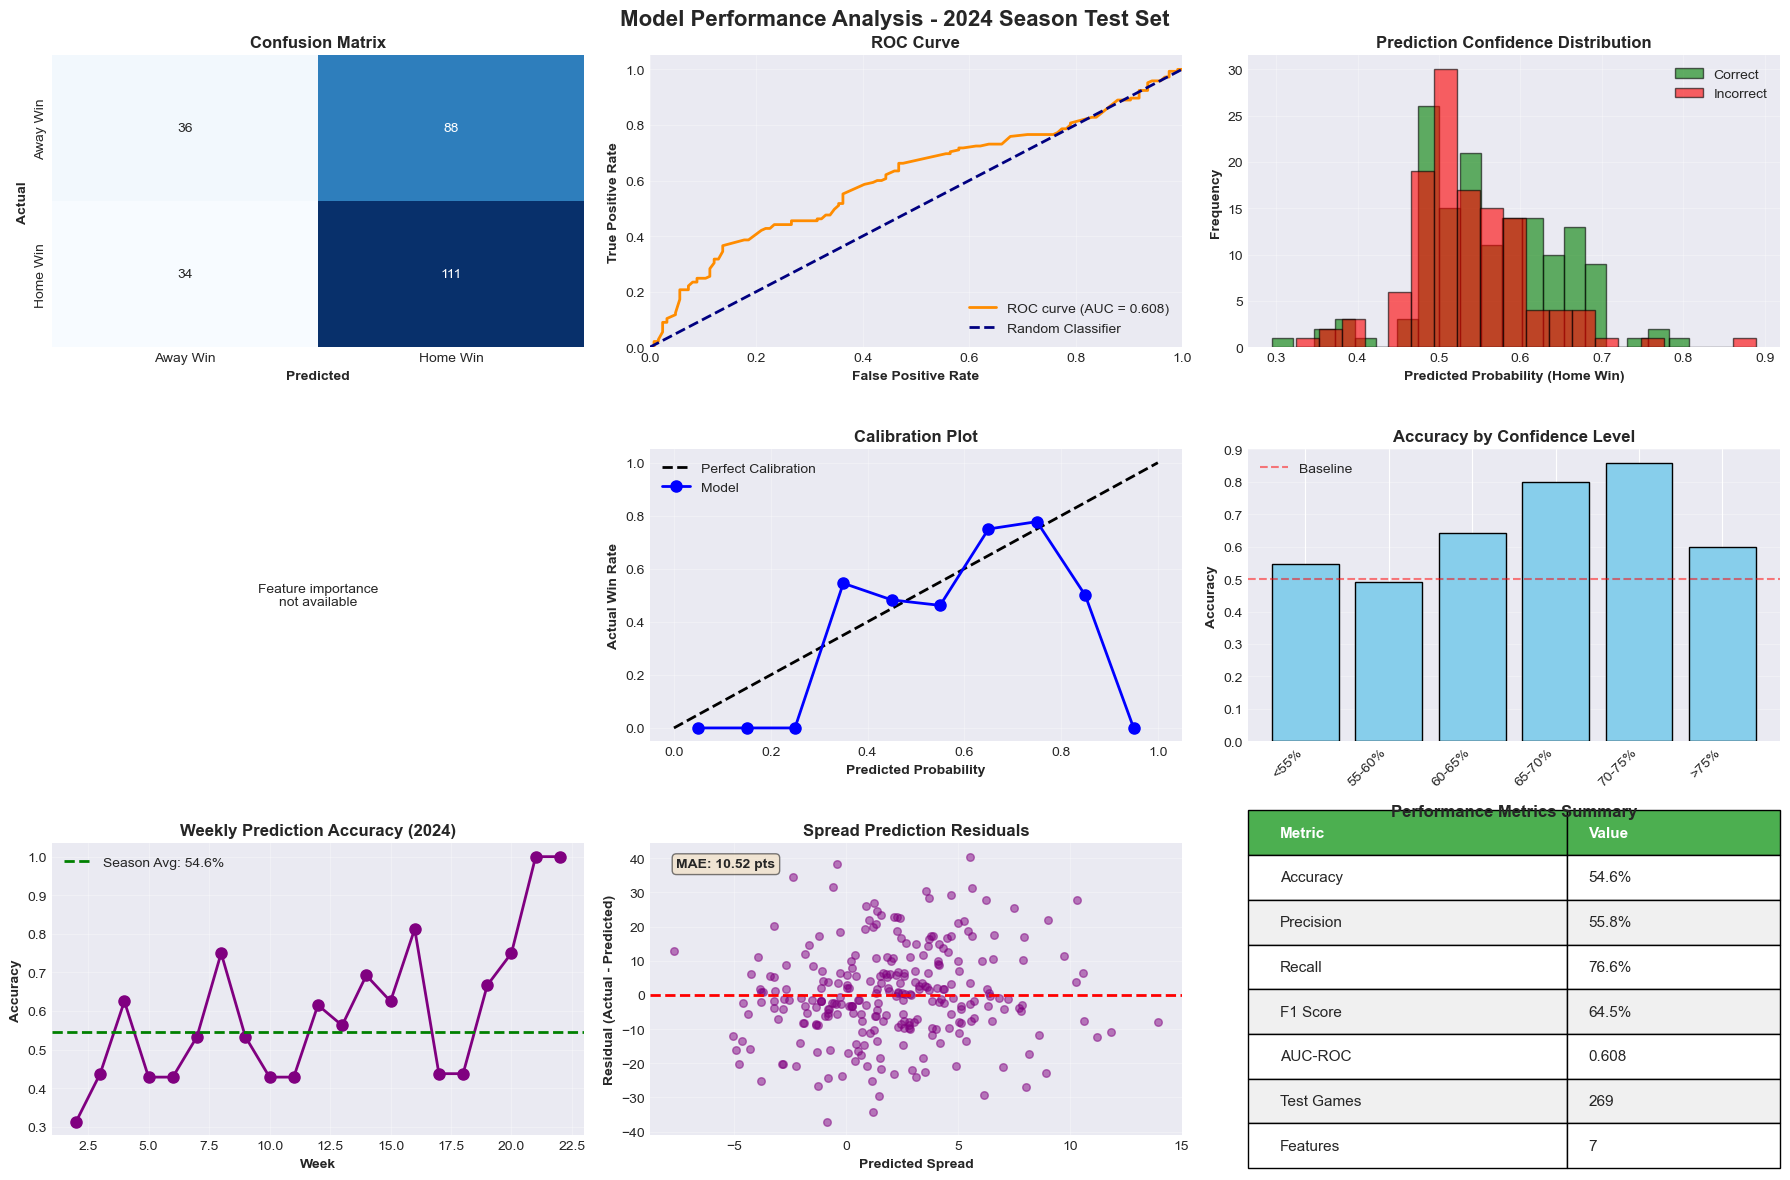

CLASSIFICATION REPORT (2024 Test Set)
              precision    recall  f1-score   support

    Away Win       0.51      0.29      0.37       124
    Home Win       0.56      0.77      0.65       145

    accuracy                           0.55       269
   macro avg       0.54      0.53      0.51       269
weighted avg       0.54      0.55      0.52       269

KEY FINDINGS
 Overall Accuracy: 54.6% on 2024 season
 AUC-ROC Score: 0.608 (>0.5 is better than random)
 High Confidence (>70%) Games: 12 games
 High Confidence Accuracy: 75.0%


In [11]:
# MODEL PERFORMANCE VISUALIZATION AND EVALUATION
# Comprehensive assessment of classification and regression model performance

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc,
                             mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split

print("MODEL PERFORMANCE RESULTS")
print("="*70)

# Check if models are trained
if 'predictor' in locals() or 'predictor' in globals():
    if hasattr(predictor, 'final_model') and predictor.final_model is not None:
        
        # Prepare test data (use 2024 season as holdout test set)
        if 'df' in locals() or 'df' in globals():
            # Split: Train on 2020-2023, Test on 2024
            train_df = df[df['season'] < 2024]
            test_df = df[df['season'] == 2024]
            
            if len(test_df) > 0:
                X_train = train_df[predictor.best_features].fillna(train_df[predictor.best_features].mean())
                y_train = train_df['home_win']
                X_test = test_df[predictor.best_features].fillna(test_df[predictor.best_features].mean())
                y_test = test_df['home_win']
                
                # Retrain model on train set
                predictor.final_model.fit(X_train, y_train)
                
                # Make predictions
                y_pred = predictor.final_model.predict(X_test)
                y_pred_proba = predictor.final_model.predict_proba(X_test)[:, 1]
                
                # Create comprehensive visualization
                fig = plt.figure(figsize=(18, 12))
                fig.suptitle('Model Performance Analysis - 2024 Season Test Set', fontsize=16, fontweight='bold')
                
                # 1. Confusion Matrix
                ax1 = plt.subplot(3, 3, 1)
                cm = confusion_matrix(y_test, y_pred)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False,
                           xticklabels=['Away Win', 'Home Win'], 
                           yticklabels=['Away Win', 'Home Win'])
                ax1.set_title('Confusion Matrix', fontweight='bold', fontsize=12)
                ax1.set_ylabel('Actual', fontweight='bold')
                ax1.set_xlabel('Predicted', fontweight='bold')
                
                # Calculate metrics from confusion matrix
                tn, fp, fn, tp = cm.ravel()
                accuracy = (tp + tn) / (tp + tn + fp + fn)
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                # 2. ROC Curve
                ax2 = plt.subplot(3, 3, 2)
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                roc_auc = auc(fpr, tpr)
                ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
                ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
                ax2.set_xlim([0.0, 1.0])
                ax2.set_ylim([0.0, 1.05])
                ax2.set_xlabel('False Positive Rate', fontweight='bold')
                ax2.set_ylabel('True Positive Rate', fontweight='bold')
                ax2.set_title('ROC Curve', fontweight='bold', fontsize=12)
                ax2.legend(loc="lower right")
                ax2.grid(True, alpha=0.3)
                
                # 3. Prediction Confidence Distribution
                ax3 = plt.subplot(3, 3, 3)
                correct_proba = y_pred_proba[(y_pred == y_test)]
                incorrect_proba = y_pred_proba[(y_pred != y_test)]
                ax3.hist(correct_proba, bins=20, alpha=0.6, label='Correct', color='green', edgecolor='black')
                ax3.hist(incorrect_proba, bins=20, alpha=0.6, label='Incorrect', color='red', edgecolor='black')
                ax3.set_xlabel('Predicted Probability (Home Win)', fontweight='bold')
                ax3.set_ylabel('Frequency', fontweight='bold')
                ax3.set_title('Prediction Confidence Distribution', fontweight='bold', fontsize=12)
                ax3.legend()
                ax3.grid(True, alpha=0.3)
                
                # 4. Feature Importance (if available)
                ax4 = plt.subplot(3, 3, 4)
                if hasattr(predictor.final_model, 'estimators_'):
                    # Extract feature importance from Random Forest in ensemble
                    try:
                        rf_model = None
                        for name, model in predictor.final_model.base_estimator.estimators:
                            if 'rf' in name.lower() or 'forest' in name.lower():
                                rf_model = model
                                break
                        
                        if rf_model and hasattr(rf_model, 'feature_importances_'):
                            importances = rf_model.feature_importances_
                            feature_names = predictor.best_features
                            indices = np.argsort(importances)[::-1][:10]  # Top 10
                            
                            ax4.barh(range(len(indices)), importances[indices], color='teal', edgecolor='black')
                            ax4.set_yticks(range(len(indices)))
                            ax4.set_yticklabels([feature_names[i] for i in indices], fontsize=9)
                            ax4.set_xlabel('Importance', fontweight='bold')
                            ax4.set_title('Top 10 Feature Importance', fontweight='bold', fontsize=12)
                            ax4.grid(True, alpha=0.3, axis='x')
                        else:
                            ax4.text(0.5, 0.5, 'Feature importance\nnot available', 
                                    ha='center', va='center', fontsize=10)
                            ax4.axis('off')
                    except:
                        ax4.text(0.5, 0.5, 'Feature importance\nnot available', 
                                ha='center', va='center', fontsize=10)
                        ax4.axis('off')
                else:
                    ax4.text(0.5, 0.5, 'Feature importance\nnot available', 
                            ha='center', va='center', fontsize=10)
                    ax4.axis('off')
                
                # 5. Calibration Plot (Reliability Diagram)
                ax5 = plt.subplot(3, 3, 5)
                # Bin predictions and calculate actual win rates
                n_bins = 10
                bins = np.linspace(0, 1, n_bins + 1)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                bin_counts = []
                bin_accuracies = []
                
                for i in range(n_bins):
                    mask = (y_pred_proba >= bins[i]) & (y_pred_proba < bins[i+1])
                    if mask.sum() > 0:
                        bin_counts.append(mask.sum())
                        bin_accuracies.append(y_test[mask].mean())
                    else:
                        bin_counts.append(0)
                        bin_accuracies.append(0)
                
                ax5.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
                ax5.plot(bin_centers, bin_accuracies, 'o-', label='Model', linewidth=2, markersize=8, color='blue')
                ax5.set_xlabel('Predicted Probability', fontweight='bold')
                ax5.set_ylabel('Actual Win Rate', fontweight='bold')
                ax5.set_title('Calibration Plot', fontweight='bold', fontsize=12)
                ax5.legend()
                ax5.grid(True, alpha=0.3)
                
                # 6. Performance by Confidence Level
                ax6 = plt.subplot(3, 3, 6)
                confidence_levels = ['<55%', '55-60%', '60-65%', '65-70%', '70-75%', '>75%']
                conf_bins = [0, 0.55, 0.60, 0.65, 0.70, 0.75, 1.0]
                conf_accuracies = []
                conf_counts = []
                
                for i in range(len(conf_bins)-1):
                    # Consider both high and low confidence (distance from 0.5)
                    mask = ((y_pred_proba >= conf_bins[i]) & (y_pred_proba < conf_bins[i+1])) | \
                           ((y_pred_proba >= (1-conf_bins[i+1])) & (y_pred_proba < (1-conf_bins[i])))
                    if mask.sum() > 0:
                        conf_counts.append(mask.sum())
                        conf_accuracies.append((y_pred[mask] == y_test[mask]).mean())
                    else:
                        conf_counts.append(0)
                        conf_accuracies.append(0)
                
                ax6.bar(range(len(confidence_levels)), conf_accuracies, color='skyblue', edgecolor='black')
                ax6.set_xticks(range(len(confidence_levels)))
                ax6.set_xticklabels(confidence_levels, rotation=45, ha='right')
                ax6.set_ylabel('Accuracy', fontweight='bold')
                ax6.set_title('Accuracy by Confidence Level', fontweight='bold', fontsize=12)
                ax6.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Baseline')
                ax6.legend()
                ax6.grid(True, alpha=0.3, axis='y')
                
                # 7. Week-by-Week Performance (2024 season)
                ax7 = plt.subplot(3, 3, 7)
                if 'week' in test_df.columns:
                    weekly_accuracy = []
                    weeks = sorted(test_df['week'].unique())
                    for week in weeks:
                        week_mask = test_df['week'] == week
                        if week_mask.sum() > 0:
                            week_acc = (y_pred[week_mask.values] == y_test[week_mask.values]).mean()
                            weekly_accuracy.append(week_acc)
                    
                    ax7.plot(weeks, weekly_accuracy, marker='o', linewidth=2, markersize=8, color='purple')
                    ax7.axhline(y=accuracy, color='green', linestyle='--', linewidth=2, label=f'Season Avg: {accuracy:.1%}')
                    ax7.set_xlabel('Week', fontweight='bold')
                    ax7.set_ylabel('Accuracy', fontweight='bold')
                    ax7.set_title('Weekly Prediction Accuracy (2024)', fontweight='bold', fontsize=12)
                    ax7.legend()
                    ax7.grid(True, alpha=0.3)
                else:
                    ax7.text(0.5, 0.5, 'Week data\nnot available', ha='center', va='center', fontsize=10)
                    ax7.axis('off')
                
                # 8. Spread Prediction Residuals (if spread model exists)
                ax8 = plt.subplot(3, 3, 8)
                if hasattr(spread_predictor, 'spread_model') and spread_predictor.spread_model is not None:
                    try:
                        # Predict spreads
                        X_test_spread = test_df[spread_predictor.best_features].fillna(test_df[spread_predictor.best_features].mean())
                        y_test_spread = test_df['home_score'] - test_df['away_score']
                        
                        # Use appropriate scaling if needed
                        if 'Linear' in str(type(spread_predictor.spread_model)):
                            X_test_spread = spread_predictor.scaler.transform(X_test_spread)
                        
                        y_pred_spread = spread_predictor.spread_model.predict(X_test_spread)
                        residuals = y_test_spread - y_pred_spread
                        
                        ax8.scatter(y_pred_spread, residuals, alpha=0.5, s=30, color='purple')
                        ax8.axhline(y=0, color='red', linestyle='--', linewidth=2)
                        ax8.set_xlabel('Predicted Spread', fontweight='bold')
                        ax8.set_ylabel('Residual (Actual - Predicted)', fontweight='bold')
                        ax8.set_title('Spread Prediction Residuals', fontweight='bold', fontsize=12)
                        ax8.grid(True, alpha=0.3)
                        
                        mae = mean_absolute_error(y_test_spread, y_pred_spread)
                        ax8.text(0.05, 0.95, f'MAE: {mae:.2f} pts', transform=ax8.transAxes, 
                                va='top', fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                    except:
                        ax8.text(0.5, 0.5, 'Spread residuals\nnot available', ha='center', va='center', fontsize=10)
                        ax8.axis('off')
                else:
                    ax8.text(0.5, 0.5, 'Spread model\nnot trained', ha='center', va='center', fontsize=10)
                    ax8.axis('off')
                
                # 9. Performance Metrics Summary Table
                ax9 = plt.subplot(3, 3, 9)
                ax9.axis('tight')
                ax9.axis('off')
                
                metrics_data = [
                    ['Metric', 'Value'],
                    ['Accuracy', f'{accuracy:.1%}'],
                    ['Precision', f'{precision:.1%}'],
                    ['Recall', f'{recall:.1%}'],
                    ['F1 Score', f'{f1:.1%}'],
                    ['AUC-ROC', f'{roc_auc:.3f}'],
                    ['Test Games', f'{len(y_test)}'],
                    ['Features', f'{len(predictor.best_features)}']
                ]
                
                table = ax9.table(cellText=metrics_data, cellLoc='left', loc='center',
                                 colWidths=[0.6, 0.4])
                table.auto_set_font_size(False)
                table.set_fontsize(11)
                table.scale(1, 2.5)
                
                # Style header row
                for i in range(2):
                    table[(0, i)].set_facecolor('#4CAF50')
                    table[(0, i)].set_text_props(weight='bold', color='white')
                
                # Alternate row colors
                for i in range(1, len(metrics_data)):
                    for j in range(2):
                        if i % 2 == 0:
                            table[(i, j)].set_facecolor('#f0f0f0')
                
                ax9.set_title('Performance Metrics Summary', fontweight='bold', fontsize=12, pad=20)
                
                plt.tight_layout()
                plt.show()
                
                # Print detailed classification report
                print("CLASSIFICATION REPORT (2024 Test Set)")
                print("="*70)
                print(classification_report(y_test, y_pred, target_names=['Away Win', 'Home Win']))
                
                print("KEY FINDINGS")
                print("="*70)
                print(f" Overall Accuracy: {accuracy:.1%} on 2024 season")
                print(f" AUC-ROC Score: {roc_auc:.3f} (>0.5 is better than random)")
                print(f" High Confidence (>70%) Games: {(np.abs(y_pred_proba - 0.5) > 0.2).sum()} games")
                high_conf_mask = np.abs(y_pred_proba - 0.5) > 0.2
                if high_conf_mask.sum() > 0:
                    high_conf_acc = (y_pred[high_conf_mask] == y_test[high_conf_mask]).mean()
                    print(f" High Confidence Accuracy: {high_conf_acc:.1%}")
                
            else:
                print("  No 2024 test data available")
        else:
            print("  Dataset 'df' not found")
    else:
        print("  Model not trained yet")
else:
    print("  Predictor not initialized")
